# Project: Wrangling and Analyzing Data

# Table of contents


1. [Data Gathering](#gathering)
    - [Loading Twitter Archive File At Hand](#load_file_at_hand)
    - [Downloading From the Web Using Requests Library](#download_using_requests)
    - [Querying Additional Data From Twitter Using Tweepy](#load_tweepy_data)
    
2. [Assessing the Data](#assessing)
     - 1. [Programmatic Assessment](#programmatic_assessment)
     - 2. [Visual Assessment of Image Data](#assessing_images)
3. [Data Issues](#issues)
     - 1. [Quality Issues](#quality_issues)
     - 2. [Tidiness Issues](#tidiness_issues)
4. [Data Cleaning](#cleaning)
    - 1. [Cleaning The Data Quality Issues](#cleaning_quality_issues)
    - 2. [Cleaning The Tidiness Issues](#cleaning_tidiness_issues)
5. [Storing Data](#storing)    
6. [Analysis and Visualization](#analysis_and_visualizations)
    - [Insights](#insights)
    


In [1]:
## Imports
import pandas as pd
import os
import requests
import numpy as np
import tweepy
import configparser
import json
import configparser
import time
import datetime
from bs4 import BeautifulSoup
from tqdm import tqdm
from IPython.display import clear_output,display,Image
import matplotlib.pyplot as plt
%matplotlib inline

## Install squarify to use to plot treemaps
!pip install squarify
clear_output()
import squarify


## Install enlighten to create progress bars
!pip install enlighten
clear_output()
import enlighten

## Install termcolor to easily print Python standard output in color for readability
!pip install termcolor
clear_output()
from termcolor import colored

## Install ipyplot to plot grids of images 
!pip install ipyplot
clear_output()
import ipyplot

<a name="gathering"></a>

## Data Gathering
In the cells below, we will gather **all** three pieces of data for this project using different methods and load them in the notebook. 

<a name="direct_download"></a>
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv', index_col='tweet_id')

<a name="download_using_requests"></a>
2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
image_predictions_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(image_predictions_url)

In [4]:
if not os.path.exists('./image_predictions.tsv'):
    with open('./image_predictions.tsv', mode='wb') as file:
        file.write(r.content)
        
## Check the files in system and their sizes
!ls -al

total 15292
drwxr-xr-x 3 root root     4096 Feb  2 23:09 .
drwxr-xr-x 1 root root     4096 Feb  2 20:19 ..
-rw-r--r-- 1 root root  1560631 Feb  2 21:59 act_report.html
-rw-r--r-- 1 root root  1285457 Feb  2 21:59 act_report.ipynb
-rw-r--r-- 1 root root      254 Jan 12 14:35 config.ini
-rw-r--r-- 1 root root   335079 Feb  2 22:32 image_predictions.tsv
drwxr-xr-x 2 root root     4096 Feb  2 22:09 .ipynb_checkpoints
-rw-r--r-- 1 root root      570 Feb  2 23:04 no_status_tweet_ids.txt
-rw-r--r-- 1 root root 10547412 Feb  2 23:04 tweets_json.txt
-rw-r--r-- 1 root root   915692 Feb  2 22:29 twitter-archive-enhanced.csv
-rw-r--r-- 1 root root   577045 Feb  2 23:04 twitter_archive_master.csv
-rw-r--r-- 1 root root    69176 Feb  2 23:09 wrangle_act.ipynb
-rw-r--r-- 1 root root   278693 Feb  2 22:19 wrangle_report.html
-rw-r--r-- 1 root root     4568 Feb  2 22:19 wrangle_report.ipynb


In [5]:
image_predictions = pd.read_csv('./image_predictions.tsv', sep='\t', index_col='tweet_id')

<a name="load_tweepy_data"></a>

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [6]:
def create_twitter_api(config_file):
    '''creates a Twitter API using tweepy given a config_file 
    input : config_file - Python configuration file
    output : Twitter API
    '''
    config = configparser.ConfigParser()
    config.read(config_file)
    
    api_key = config['twitter']['api_key']
    api_key_secret = config['twitter']['api_key_secret']
    access_token = config['twitter']['access_token']
    access_token_secret = config['twitter']['access_token_secret']

    auth = tweepy.OAuthHandler(api_key, api_key_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True, retry_count=3, retry_delay=0.2)
    return api


In [7]:
if os.path.exists('config.ini'):
    api = create_twitter_api('config.ini')

**NOTE :** In the final submission, the config file will not be included hence the `create_twitter_api` function will not run as expected

In [8]:
def write_tweets_json_txt(tweet_ids, file):

    num_status_tweet_ids=0   
    no_status_tweet_ids = []
    
    if os.path.exists(file):
            st_mode, _, _, _, _ ,_,st_size, st_atime, st_mtime,_ = os.stat(file)
            if st_mode ==33188: ## if it is a text file
                create_time = datetime.datetime.fromtimestamp(st_mtime).strftime('%A, %B %d, %Y %I:%M:%S')
                last_access_time = datetime.datetime.fromtimestamp(st_atime).strftime('%A, %B %d, %Y %I:%M:%S')
                print("\n\tjson text file already exists.")
                print(f"\tFile Size        : {st_size/1024/1024:.2f} MB")
                print(f"\tCreated On       : {create_time}")
                print(f"\tLast Accessed On : {last_access_time}")

                user_input = ''
                while user_input not in ['y', 'n']:
                    user_input = input("\n\tDo you want to remove the existing json text file and redownload Twitter api data? [Y/N]\n\t").strip().lower()
                if user_input=='n':
                    print('\nFetching no_status_tweet_ids from text file')
                    with open('no_status_tweet_ids.txt', mode='r', encoding='utf-8') as f:
                        no_status_tweet_ids = [int(i) for i in f.read().split('\n')[:-1]]
                    return no_status_tweet_ids

                elif user_input=='y':
                    os.remove(file)
                    print(f'\njson text file removed')

        
    manager = enlighten.get_manager()
    tweed_ids_manager =             manager.counter(total=len(tweet_ids), desc="tweet_ids attempted   : ", unit="tweet_ids", color="blue")
    available_tweet_ids_manager =   manager.counter(total=len(tweet_ids), desc="tweet_ids available   : ", unit="tweet_ids", color="green")
    unavailable_tweet_ids_manager = manager.counter(total=len(tweet_ids), desc="tweet_ids unavailable : ", unit="tweet_ids", color="red")


    for tweet_id in tweet_ids:
        tweed_ids_manager.update()
        try :
            tweet = api.get_status(id=tweet_id, tweet_mode='extended')
            with open(file, mode='a', encoding='utf-8') as f:
                f.write(json.dumps(tweet._json))
                f.write('\n')
            available_tweet_ids_manager.update()

        except : 
            no_status_tweet_ids.append(tweet_id)
            num_status_tweet_ids += 1 
            #print(f'({num_status_tweet_ids}):   Missing ID : {tweet_id}')
            unavailable_tweet_ids_manager.update()
            
    print()
    print(f"Total Number of tweet_ids attempted              : {len(tweet_ids)} ")
    print(f"Total Number of tweets gathered from twitter API : {len(tweet_ids)-num_status_tweet_ids} ")
    print(f"Total Number of tweet_ids unavailable            : {num_status_tweet_ids} ")
    
    with open('no_status_tweet_ids.txt', mode='w', encoding='utf-8') as f:
        write_string = "".join([str(i)+'\n' for i in no_status_tweet_ids])
        f.write(write_string)
    
    return no_status_tweet_ids


In [9]:
tweet_ids = twitter_archive.index.values
json_file = './tweets_json.txt'
no_status_tweet_ids = write_tweets_json_txt(tweet_ids, json_file)


	json text file already exists.
	File Size        : 10.06 MB
	Created On       : Thursday, February 02, 2023 11:04:45
	Last Accessed On : Thursday, February 02, 2023 11:04:47

	Do you want to remove the existing json text file and redownload Twitter api data? [Y/N]
	n

Fetching no_status_tweet_ids from text file


In [10]:
def create_df_from_json_text(json_text_file):
    df_lis = []
    with open(json_text_file, mode='r', encoding='utf-8') as f:
        lines = f.read().split('\n')[:-1]
        print(f"\nNumber of records found in the json data text file : {len(lines)}")
        counter = 0
        for line in lines:
            counter +=1
            #print(counter, line)
            tweet = json.loads(line)
            tweet_params = {
                'tweet_id' : tweet['id'],
                'retweet_count' : tweet['retweet_count'],
                'favorite_count' : tweet['favorite_count'],
                'hashtags' : tweet['entities']['hashtags'],
                'user_mentions' : tweet['entities']['user_mentions'],
                'text':tweet['full_text'],
                
            }
            df_lis.append(tweet_params)
    return df_lis


In [11]:
json_file = './tweets_json.txt'
df_list = create_df_from_json_text(json_file)
api_data_df = pd.DataFrame(df_list)
api_data_df.set_index('tweet_id', inplace=True)



Number of records found in the json data text file : 2326


In [12]:
print('Hello')

Hello


<a name="assessing"></a>
## Assessing Data
In this section, we detect and document at least **eight (8) quality issues and two (2) tidiness issue**. To achieve this we use **both** visual and programmatic assessement.

**Note:** While assessing the data we pay attention to the following key points:

* We only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time. Therefore, we will only aim to identify and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* For this project, we do not need to gather the tweets beyond August 1st, 2017. This is because we have image predictions for tweets only before this date and don't have access to the algorithm used.

<a name="programmatic_assessment"></a>

### Programmatic Assessment 


In [13]:
## Sample 10 rows for visual inspection
twitter_archive.sample(10)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
808838249661788160,NaN,NaN,2016-12-14 00:57:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ito. He'll be your uber driver tonight...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808838249...,13,10,Ito,None,None,None,None
668992363537309700,NaN,NaN,2015-11-24 03:19:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Harrison. He braves the snow like a ch...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668992363...,8,10,Harrison,None,None,None,None
688211956440801280,NaN,NaN,2016-01-16 04:11:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Derby. He's a superstar. 13/10 (vid by...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/688211956...,13,10,Derby,None,None,None,None
876484053909872640,NaN,NaN,2017-06-18 16:57:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Benedict. He wants to thank you for th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/876484053...,13,10,Benedict,None,None,None,None
832369877331693569,NaN,NaN,2017-02-16 23:23:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Charlie. He fell asleep on a heating v...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/832369877...,11,10,Charlie,None,None,None,None
674606911342424069,6.744689e+17,4.196984e+09,2015-12-09 15:09:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The 13/10 also takes into account this impecca...,NaN,NaN,NaN,NaN,13,10,None,None,None,None,None
720059472081784833,NaN,NaN,2016-04-13 01:22:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Charleson. He lost his plunger. Looked...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/720059472...,9,10,Charleson,None,None,None,None
800751577355128832,NaN,NaN,2016-11-21 17:23:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Mauve and Murphy. They're rather ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/800751577...,12,10,Mauve,None,None,None,None
674999807681908736,6.747934e+17,4.196984e+09,2015-12-10 17:11:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ok last one of these. I may try to make some m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674999807...,13,10,None,None,None,None,None


In [14]:
## Inspect the data types of the columns of twitter_archive table and the number of Null values per column
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 16 columns):
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), object(10)
memory usa

In [15]:
## Check for duplicated tweet ids. There shouldn't be any duplicates as the tweet id is a unique identifier
twitter_archive.index.duplicated().sum()

0

In [16]:
## Sample 10 image_predictions rows for visual inspection
image_predictions.sample(10)

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,
681302363064414209,https://pbs.twimg.com/media/CXR44l9WcAAcG_N.jpg,1,frilled_lizard,0.326259,False,tailed_frog,0.104539,False,axolotl,0.072479,False
718540630683709445,https://pbs.twimg.com/media/CfjE5FRXEAErFWR.jpg,2,Maltese_dog,0.632289,True,West_Highland_white_terrier,0.187055,True,cairn,0.044413,True
681579835668455424,https://pbs.twimg.com/media/CXV1Ot_W8AEpkQO.jpg,1,Rottweiler,0.760671,True,Labrador_retriever,0.096585,True,Staffordshire_bullterrier,0.040333,True
689877686181715968,https://pbs.twimg.com/media/CZLwGAIWQAIYsTx.jpg,1,Old_English_sheepdog,0.269155,True,Tibetan_terrier,0.111496,True,Lakeland_terrier,0.104939,True
785264754247995392,https://pbs.twimg.com/media/CuXSHNnWcAIWEwn.jpg,1,teddy,0.674893,False,cradle,0.056740,False,chow,0.056137,True
670474236058800128,https://pbs.twimg.com/media/CU4AwqQWUAAEgE2.jpg,1,wool,0.070076,False,siamang,0.062536,False,gorilla,0.058894,False
834086379323871233,https://pbs.twimg.com/media/C5NFIsjWQAEI93t.jpg,1,bath_towel,0.736759,False,sleeping_bag,0.062959,False,Labrador_retriever,0.045263,True
695051054296211456,https://pbs.twimg.com/media/CaVRP4GWwAERC0v.jpg,1,Boston_bull,0.761454,True,pug,0.075395,True,Chihuahua,0.041598,True
786963064373534720,https://pbs.twimg.com/media/Cuvau3MW8AAxaRv.jpg,1,golden_retriever,0.915303,True,Saluki,0.046213,True,Labrador_retriever,0.037504,True


In [17]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 666020888022790149 to 892420643555336193
Data columns (total 11 columns):
jpg_url    2075 non-null object
img_num    2075 non-null int64
p1         2075 non-null object
p1_conf    2075 non-null float64
p1_dog     2075 non-null bool
p2         2075 non-null object
p2_conf    2075 non-null float64
p2_dog     2075 non-null bool
p3         2075 non-null object
p3_conf    2075 non-null float64
p3_dog     2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 152.0+ KB


In [18]:
image_predictions.index.duplicated().sum()

0

In [19]:
## Sample 10 api_data_df rows for inspection
api_data_df.sample(10)

,favorite_count,hashtags,retweet_count,text,user_mentions
tweet_id,,,,,
707038192327901184,1971,[],698,This is Kathmandu. He sees every move you make...,[]
669942763794931712,434,[],129,This is Andru. He made his very own lacrosse s...,[]
876838120628539392,17642,[],2743,This is Ginger. She's having a ruff Monday. To...,[]
705428427625635840,3411,[],1491,This is Ambrose. He's an Alfalfa Ballyhoo. Dra...,[]
838150277551247360,1531,[],295,@markhoppus 182/10,"[{'screen_name': 'markhoppus', 'name': 'mark h..."
843981021012017153,13702,[],2648,HE WAS DOING A SNOOZE NO SHAME IN A SNOOZE 13/...,[]
666273097616637952,148,[],66,Can take selfies 11/10 https://t.co/ws2AMaNwPW,[]
780092040432480260,0,[],2080,RT @dog_rates: This is Hank. He's mischievous ...,"[{'screen_name': 'dog_rates', 'name': 'WeRateD..."
780074436359819264,11114,[],4480,Here's a doggo questioning his entire existenc...,[]


In [20]:
api_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2326 entries, 892420643555336193 to 666020888022790149
Data columns (total 5 columns):
favorite_count    2326 non-null int64
hashtags          2326 non-null object
retweet_count     2326 non-null int64
text              2326 non-null object
user_mentions     2326 non-null object
dtypes: int64(2), object(3)
memory usage: 109.0+ KB


In [21]:
## Check the frequency of occurence of 50 most common names in the twitter_archive table
twitter_archive['name'].value_counts().head(50)

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
Oliver      11
Lola        10
Penny       10
Tucker      10
Bo           9
Winston      9
the          8
Sadie        8
Buddy        7
Toby         7
Daisy        7
an           7
Bailey       7
Rusty        6
Jax          6
Milo         6
Stanley      6
Bella        6
Dave         6
Leo          6
Koda         6
Scout        6
Oscar        6
Jack         6
Larry        5
Alfie        5
Sunny        5
George       5
Oakley       5
Gus          5
Chester      5
Louis        5
Phil         5
Sammy        5
Bentley      5
Finn         5
very         5
just         4
Ruby         4
Gerald       4
Luna         4
Bruce        4
Shadow       4
Carl         4
Brody        4
Name: name, dtype: int64

<a name="assessing_images"></a>

## Visual Assessment of Image Data
> Here, we load some of the images for visual assessment as this is the most appropriate way to assess image data

> We start by defining some functions that will help make it easier to load the image data and the relevant data for each of the images

In [22]:
## plot to add color to standard outputs for visibility 
def add_color(text, color='blue', attrs=['bold']):
    return colored(text, color, attrs=attrs)

## function to plot the images and add relevant data
def create_image_visualizations(image_preds_df):
    sample_preds = image_preds_df.copy()
    for pred in ['p1', 'p2', 'p3']:
        sample_preds[pred+'_dog'] = sample_preds[pred+'_dog'].apply(lambda x : 
                                        add_color(' (dog breed)', 'green') if x else add_color(' (not a dog)', 'red'))
        sample_preds[pred] = sample_preds[pred].apply(add_color, 'black') + sample_preds[pred+'_dog']
        #sample_preds[pred] = sample_preds[pred].str.pad(sample_preds[pred].str.len().max(), 'right')
        sample_preds.drop(columns=pred+'_dog', inplace=True)

    padlen = max([sample_preds[p].str.len().max() for p in ['p1', 'p2', 'p3']])

    for sample_ind in sample_preds.index:
        print(add_color(f'Sample Image ID {sample_ind+1} : ', color='red'))
        display(Image(sample_preds['jpg_url'][sample_ind], height=150, width=150))
        print(f"First prediction  : {sample_preds['p1'][sample_ind]:{padlen}}    Confidence Level : {add_color(sample_preds['p1_conf'][sample_ind])}")
        print(f"Second prediction : {sample_preds['p2'][sample_ind]:{padlen}}    Confidence Level : {add_color(sample_preds['p2_conf'][sample_ind])}")    
        print(f"Third prediction  : {sample_preds['p3'][sample_ind]:{padlen}}    Confidence Level : {add_color(sample_preds['p3_conf'][sample_ind])}\n\n")        


		Sample Images in The Dataset : 

Sample Image ID 830583320585068545 : 


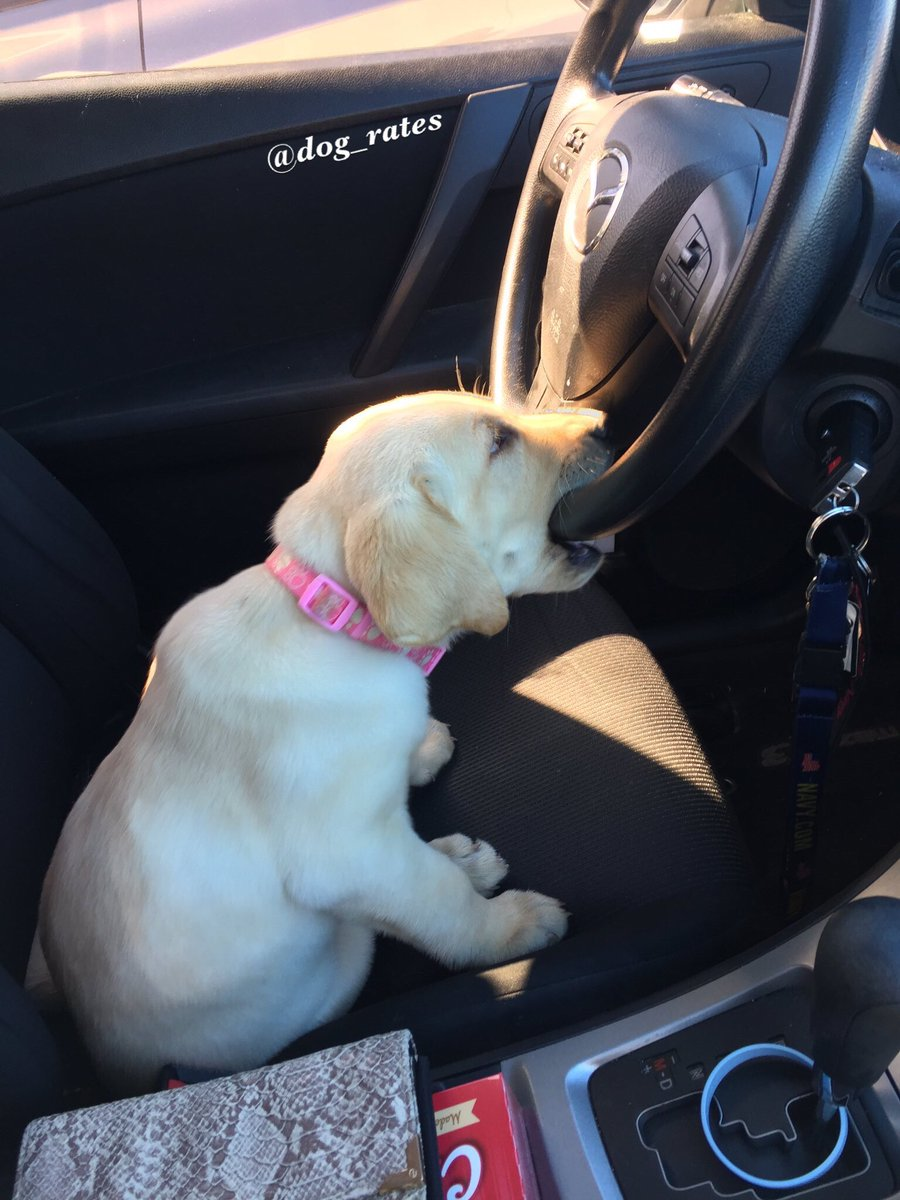

First prediction  : Labrador_retriever (dog breed)           Confidence Level : 0.908703
Second prediction : seat_belt (not a dog)                    Confidence Level : 0.0570909
Third prediction  : pug (dog breed)                          Confidence Level : 0.0119335


Sample Image ID 701889187134500866 : 


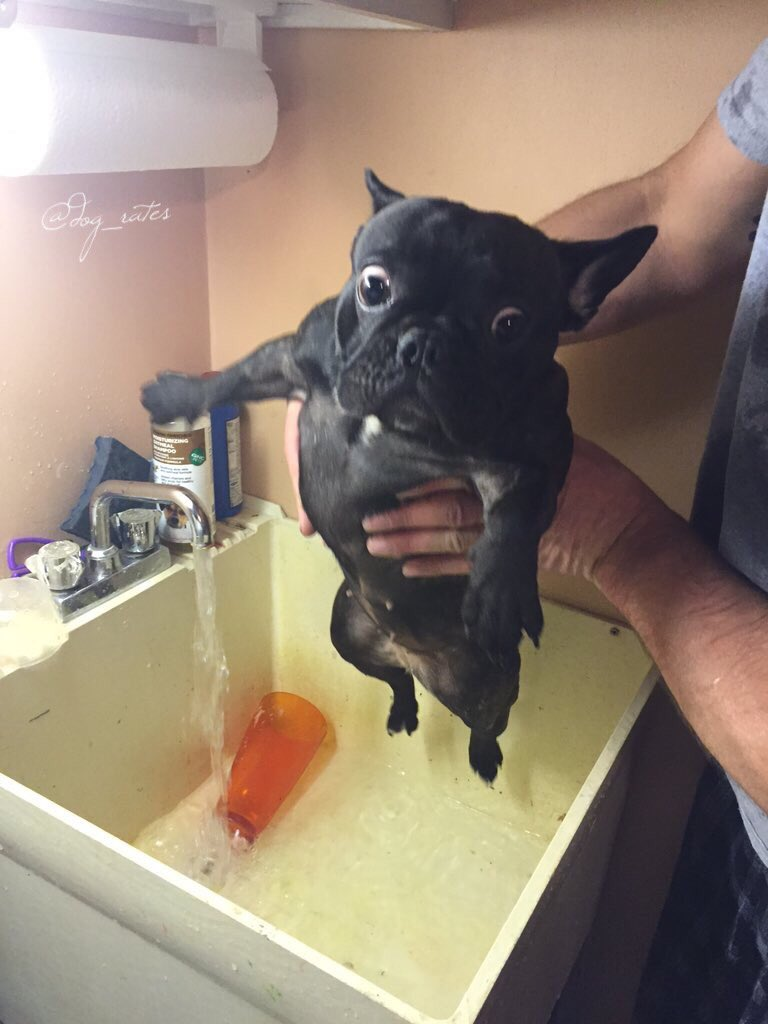

First prediction  : French_bulldog (dog breed)               Confidence Level : 0.902856
Second prediction : Staffordshire_bullterrier (dog breed)    Confidence Level : 0.0226341
Third prediction  : soap_dispenser (not a dog)               Confidence Level : 0.0119732


Sample Image ID 681242418453299202 : 


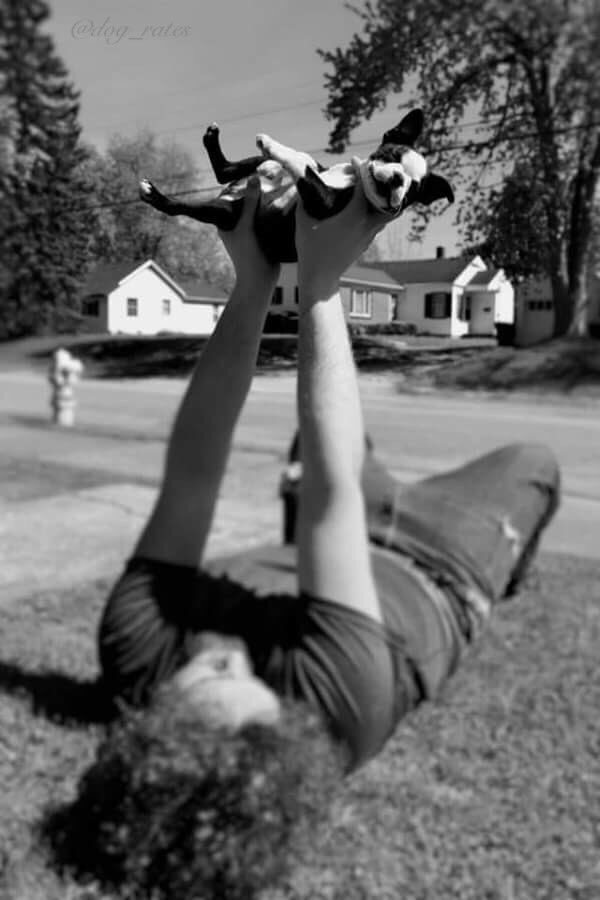

First prediction  : motor_scooter (not a dog)                Confidence Level : 0.255934
Second prediction : rifle (not a dog)                        Confidence Level : 0.145202
Third prediction  : assault_rifle (not a dog)                Confidence Level : 0.0970001


Sample Image ID 832757312314028033 : 


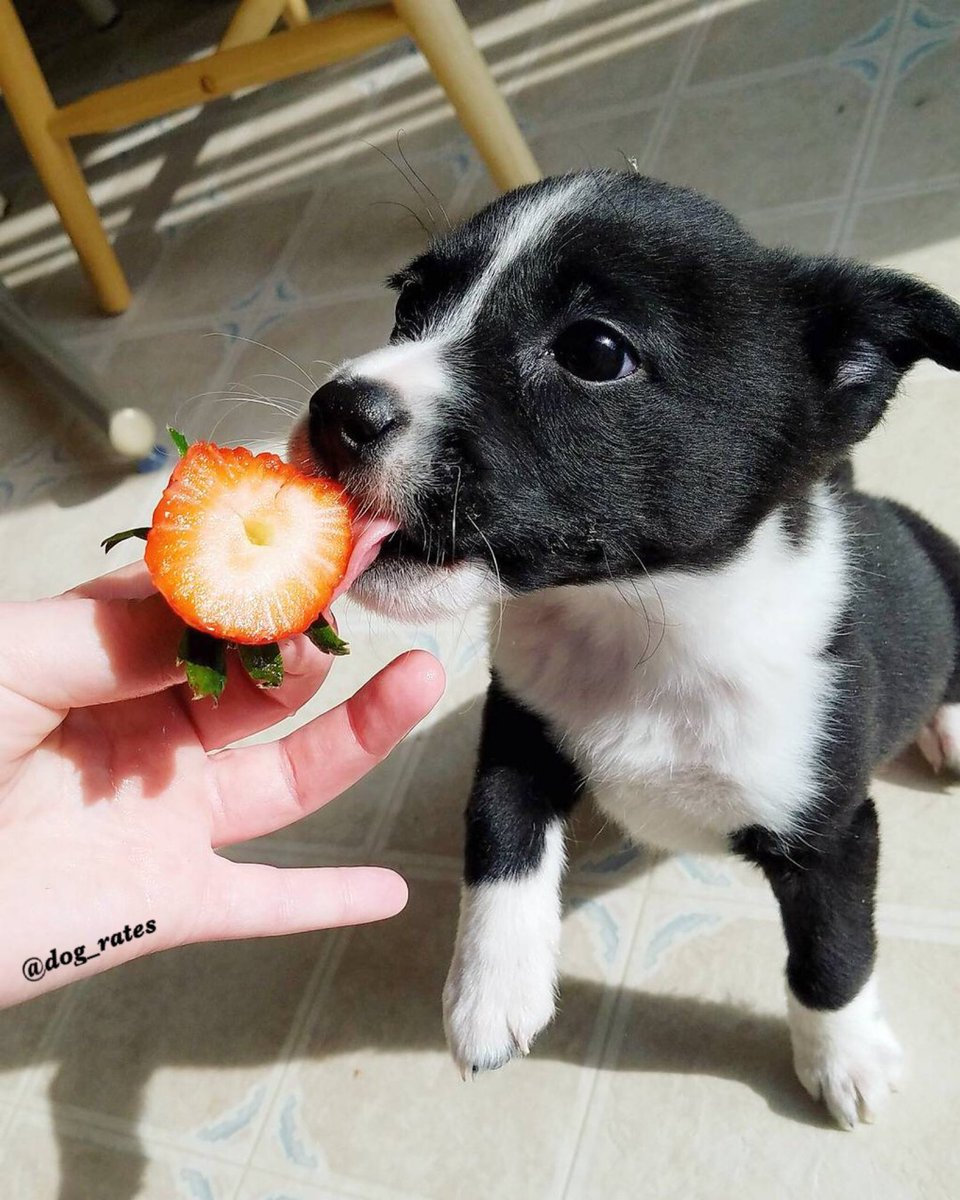

First prediction  : Cardigan (dog breed)                     Confidence Level : 0.160888
Second prediction : Staffordshire_bullterrier (dog breed)    Confidence Level : 0.159441
Third prediction  : Boston_bull (dog breed)                  Confidence Level : 0.154368


Sample Image ID 693095443459342337 : 


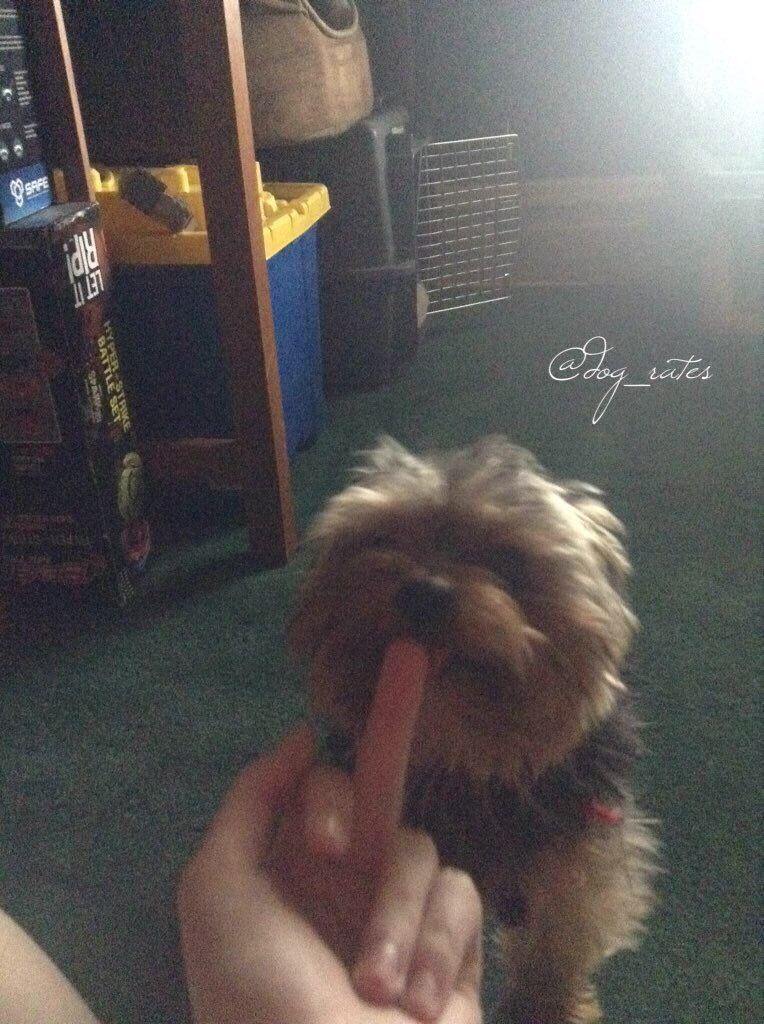

First prediction  : ice_lolly (not a dog)                    Confidence Level : 0.660099
Second prediction : neck_brace (not a dog)                   Confidence Level : 0.0395629
Third prediction  : Yorkshire_terrier (dog breed)            Confidence Level : 0.0334878




In [23]:
sample_images = image_predictions.sample(5, random_state=1234)
print(add_color("\n\t\tSample Images in The Dataset : \n"))
create_image_visualizations(sample_images)


		Sample Images That Were Not predicted To Contain Dogs : 

Sample Image ID 788039637453406210 : 


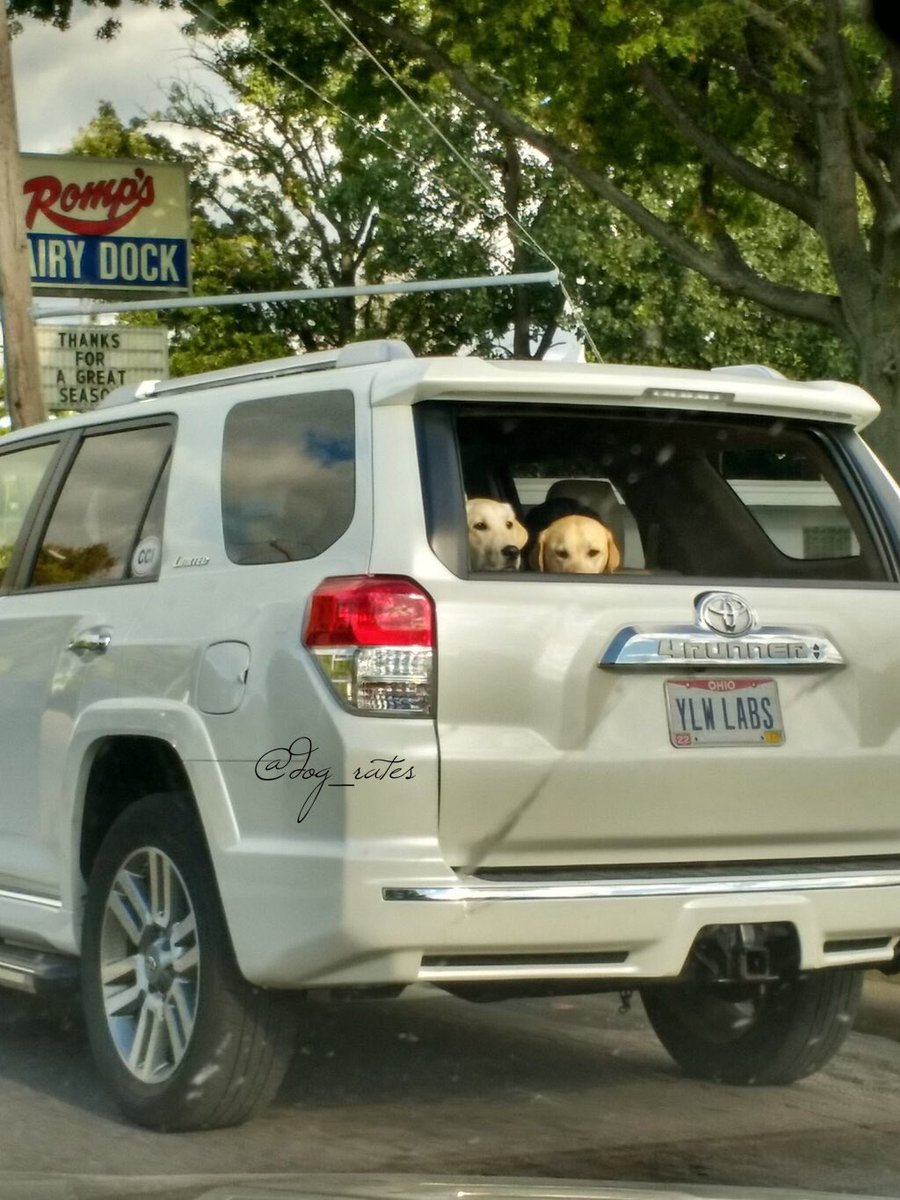

First prediction  : beach_wagon (not a dog)           Confidence Level : 0.362925
Second prediction : minivan (not a dog)               Confidence Level : 0.304759
Third prediction  : limousine (not a dog)             Confidence Level : 0.101702


Sample Image ID 697482927769255937 : 


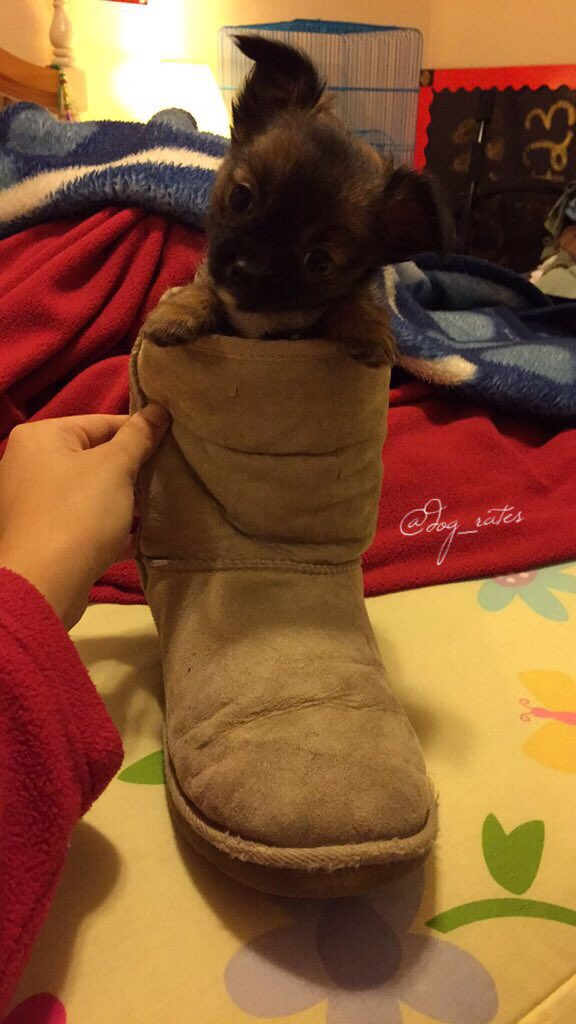

First prediction  : bath_towel (not a dog)            Confidence Level : 0.110587
Second prediction : Christmas_stocking (not a dog)    Confidence Level : 0.108573
Third prediction  : weasel (not a dog)                Confidence Level : 0.105442


Sample Image ID 668645506898350082 : 


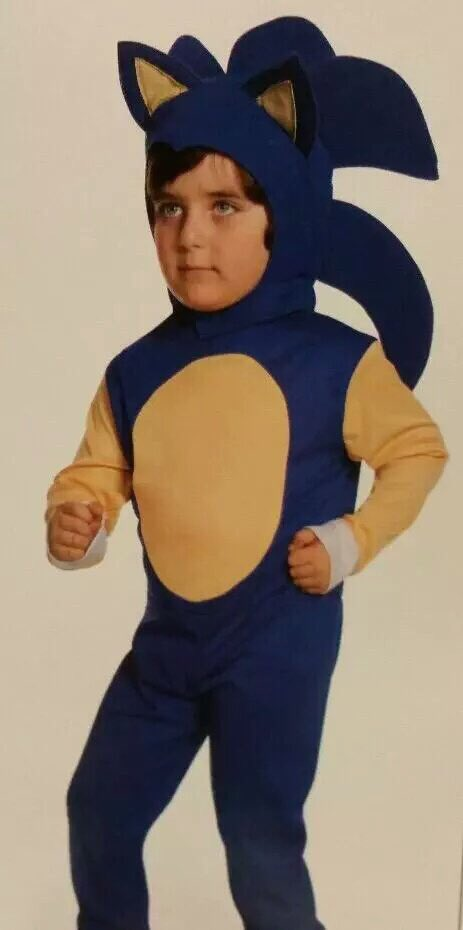

First prediction  : ski_mask (not a dog)              Confidence Level : 0.302854
Second prediction : knee_pad (not a dog)              Confidence Level : 0.0968812
Third prediction  : balance_beam (not a dog)          Confidence Level : 0.0840756




In [24]:
non_dog_image_predictions = image_predictions[image_predictions[['p1_dog', 'p2_dog', 'p3_dog']].sum(axis=1)==0]
sample_non_dogs = non_dog_image_predictions.sample(3, random_state=12345)
print(add_color("\n\t\tSample Images That Were Not predicted To Contain Dogs : \n"))
create_image_visualizations(sample_non_dogs)



		Dog image predictions with highest confidence level : 

Sample Image ID 668636665813057537 : 


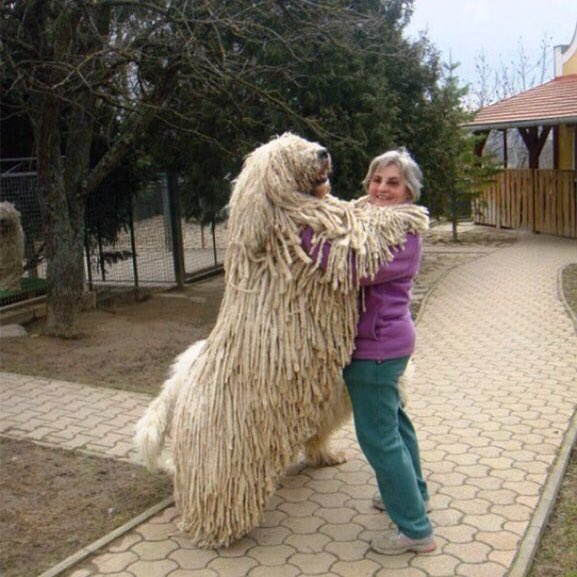

First prediction  : komondor (dog breed)              Confidence Level : 0.999956
Second prediction : llama (not a dog)                 Confidence Level : 4.30981e-05
Third prediction  : ram (not a dog)                   Confidence Level : 2.1609e-07


Sample Image ID 762464539388485634 : 


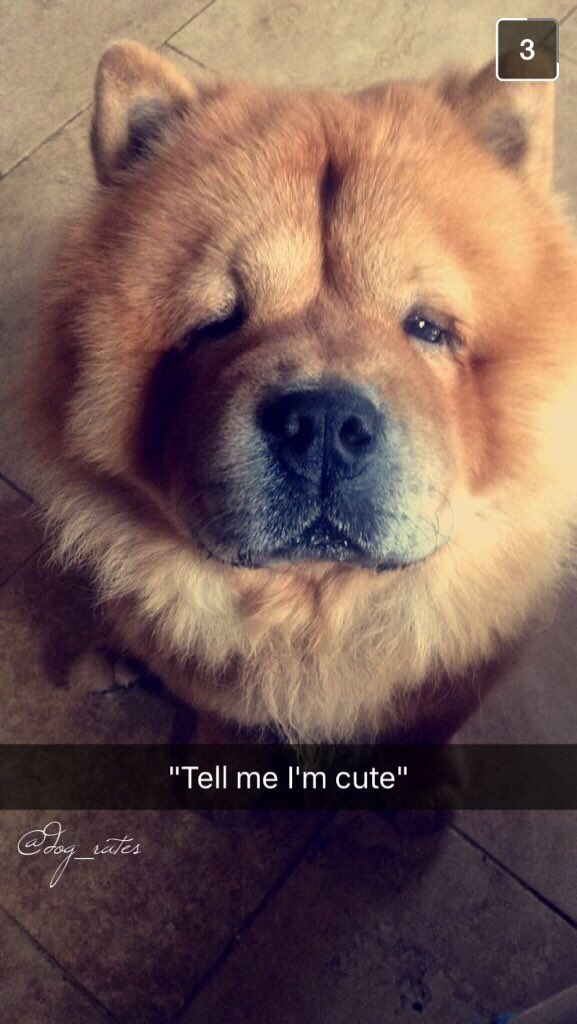

First prediction  : chow (dog breed)                  Confidence Level : 0.999953
Second prediction : Tibetan_mastiff (dog breed)       Confidence Level : 2.33591e-05
Third prediction  : dhole (not a dog)                 Confidence Level : 3.01033e-06


Sample Image ID 697463031882764289 : 


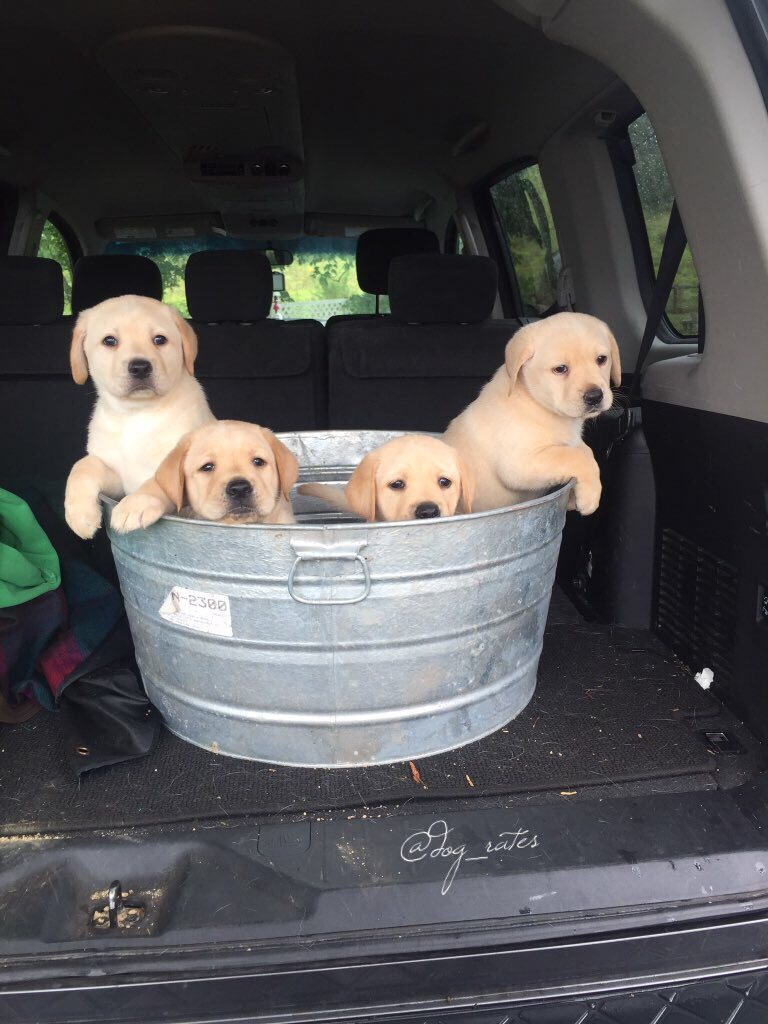

First prediction  : Labrador_retriever (dog breed)    Confidence Level : 0.999885
Second prediction : golden_retriever (dog breed)      Confidence Level : 9.75817e-05
Third prediction  : pug (dog breed)                   Confidence Level : 8.26776e-06




In [25]:
## Dog image predictions with highest confidence level
dog_image_predictions = image_predictions[image_predictions[['p1_dog', 'p2_dog', 'p3_dog']].sum(axis=1)>0]
dogs_highest_conf = dog_image_predictions[dog_image_predictions['p1_dog']==True].sort_values(by='p1_conf', ascending=False).head(3)
print(add_color('\n\t\tDog image predictions with highest confidence level : \n'))
create_image_visualizations(dogs_highest_conf)

<a name="issues"></a>

## DATA ISSUES
> Here we list some of the quality and tidiness issues identified during the assessment step above.


<a name="quality_issues"></a>
## Quality issues
####  twitter_archive table
> 1) some of the rows in the table contain retweets. We are only interested in original ratings (non-retweets) for this particular project

> 2) Erroneous datatype : timestamp column - object(string) instead of datetime 

> 3) null values in the `name` column represented as **'None'** instead of as valid pandas null representation : **NaN**.  
   There are also invalid names such as `a`,`an` and `very` which we will need to remove

> 4) plurals such as 'puppers' were not considered for cases where dog squads ie more than one dog in the picture, were being rated

> 4) some tweets are ratings of more than one dog in the same picture and they seem to have a different rating system where the numerator and denominator are each multiplied by the number of dogs in the picture. These should be adjusted to the common doggo rating system where the rating denominator is 10 for easier analysis

> 5) some datetetime parameters such as 24/7, 9/11, 4/20 have been accidentally interpreted as ratings values. '50/50 split' was also misinterpreted as a dog rating

> 6) some tweet texts contain more than one parameters similar to the ratings style used. The first ratings format occurence was automatically taken as the rating while in some cases the second occurence was the actual rating.

> 7) some ratings are not reflective of the good ol doggo rating system we are familiar with and are meant to be funny or satirical such as one tweet rating a dog 666/10 or another rating a 'Snoop doggo' 420/10. To be fair to the other good doggos in the dataset, we are going to get rid of such outlier ratings.

> 8) many urls in the `expanded_urls` column are duplicated

> 8) Most of the dog names are invalid eg name `'a'` with 55 occurences, `'the'` with 8 occurences and `'an'` with 7 occurences.

> 9) Source device in the `source` column is enclosed in html tags


#### image_predictions table
> 10) some of the tweets are not related to dogs.

#### api_data_df table
> 11) null hashtags and user_mentions represented as empty Python lists of pandas recognized null representation.




<a name="tidiness_issues"></a>
## Tidiness issues
> 1) `doggo`, `floofer`, `pupper`, `puppo` columns in the twitter_archive table should be represented as variables in one column `dog_stage`

> 2) the three tables : `api_data_df`, `twitter_archive` and `image_predictions` should be collapsed into one master table with the relevant data from all three tables.



<a name="cleaning"></a>


## Cleaning Data
> In this section, we will clean **all** of the issues documented above when assessing the data contained in the three tables.   
 Before we start the cleaning process, we make copies of the original data


In [26]:
## Make soon to be clean copies of the three tables to work on
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
api_data_df_clean = api_data_df.copy()

In [27]:
## Increase the maximum number of characters displayed by Pandas Columns to + readability of the text column
pd.options.display.max_colwidth = 150

## Add a new rating column with the format 'r_numerator/r_denominator'
twitter_archive_clean['rating'] = twitter_archive_clean['rating_numerator'].astype(str) + '/' + twitter_archive_clean['rating_denominator'].astype(str)


<a name="cleaning_quality_issues"></a>

### Cleaning The Data Quality Issues

### Issue #1: 
> some of the rows in the `twitter_archive` table contain retweets. 

#### Define :  
> Remove rows from the `twitter_archive` table that are retweets. These are the tweets with non-null retweet_status_ids

#### Code :

In [28]:
print(f"\nNumber of retweets in the twitter_archive_clean table before cleaning :  {int(twitter_archive_clean.retweeted_status_id.notnull().sum())}")
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]


Number of retweets in the twitter_archive_clean table before cleaning :  181


In [29]:
## Test ::
print(f"\nNumber of retweets in the twitter_archive_clean table after cleaning :  {int(twitter_archive_clean.retweeted_status_id.notnull().sum())}")


Number of retweets in the twitter_archive_clean table after cleaning :  0


### Issue #2: 
> Erroneous datatype : timestamp column - object(string) instead of datetime

#### Define :  
> change the timestamp column in the `twitter_archive_clean` table to datetime type

#### Code :

In [30]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean.timestamp)

In [31]:
## Test :
## Check the data type of the timestamp column
twitter_archive_clean[['timestamp']].dtypes

timestamp    datetime64[ns]
dtype: object

In [32]:
## Check the earliest and latest dates represented in the dataset
print(f"Earliest date represented in the dataset : {twitter_archive_clean['timestamp'].min().date()}")
print(f"Latest date represented in the dataset   : {twitter_archive_clean['timestamp'].max().date()}")

Earliest date represented in the dataset : 2015-11-15
Latest date represented in the dataset   : 2017-08-01


### Issue #3: 
> null values in the `name` column represented as 'None'.

#### Define :  
> replace `None` in the `name` column of the `twitter_archive_clean` table with numpy NaNs 
#### Code :

In [33]:
twitter_archive_clean['name'].replace('None', np.nan, inplace=True)


In [34]:
invalid_dog_names = ['a', 'an', 'the', 'one', 'very']
twitter_archive_clean.name = twitter_archive_clean.name.apply(lambda x : np.nan if x in invalid_dog_names else x)

In [35]:
## Test ::
## Check that there are no longer 'None' in the name column
print('None' in twitter_archive_clean['name'].values)

False


### Issue #4: 
> some tweets are ratings of more than one dog in the same picture and they seem to have a different rating system where the numerator and denominator are each multiplied by the number of dogs in the picture. These should be adjusted to the common doggo rating system where the rating denominator is 10 for easier analysis

#### Define :  
> look for rows where the `rating_denominator` is a multiple of 10 and the `rating_numerator` is divisible by the number `rating_denominator/10`

#### Code :


In [36]:
dog_squads_df = twitter_archive_clean[twitter_archive_clean['rating_denominator'].apply(lambda x : str(x)[-1]=='0' and x>10)].copy()
dog_squads_df['adjusted_numerator'] = (dog_squads_df['rating_numerator']/dog_squads_df['rating_denominator']*10).astype(int)
dog_squads_df['adjusted_denominator'] = 10


In [37]:
dog_squads_df['rating'] = dog_squads_df['adjusted_numerator'].astype(str) + '/' +dog_squads_df['adjusted_denominator'].astype(str)

In [38]:
## Effect the changes to the main twitter_archive_clean 'rating' column 
twitter_archive_clean.loc[dog_squads_df.index, 'rating'] = dog_squads_df['rating']

### Issue #5: 
> some datetetime parameters such as 24/7, 9/11, 4/20 have been accidentally interpreted as ratings values. '50/50 split' was also misinterpreted as a dog rating

#### Define :  
> look for common datetime parameters such as 24/7 and 9/11 that are in the format of the ratings and thus likely to have been misinterpreted as such

#### Code :



In [39]:
datetime_ratings = twitter_archive_clean.query("rating in ['24/7', '4/20', '50/50', '9/11']")[['text','rating']]
datetime_ratings

,text,rating
tweet_id,,
810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t ...,24/7
740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9/11


In [40]:
def make_manual_corrections(df, col, corr_map):
    '''replaces changes in the 'col'column of 'df' using the corr_map dictionary mapping '''
    for key in corr_map.keys():
        df.loc[key,col] = corr_map[key]
        
rating_mode = twitter_archive_clean.rating.mode()[0]
datetime_ratings_corrections = {
    810984652412424192 : rating_mode, # 516
    740373189193256964 : '14/10', #1068
}


make_manual_corrections(datetime_ratings, 'rating', datetime_ratings_corrections)
datetime_ratings

,text,rating
tweet_id,,
810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t ...,12/10
740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14/10


In [41]:
twitter_archive_clean.loc[datetime_ratings.index, 'rating'] = datetime_ratings['rating']

### Issue #6: 
> some tweet texts contain more than one parameters similar to the ratings style used. The first ratings format occurence was automatically taken as the rating while in some cases the second occurence was the actual rating.

#### Define :  
> use regular expressions to find tweet texts with occurences of more than one potential rating.

#### Code :




In [42]:
## double_ratings instead of confusing_ratings
double_ratings = twitter_archive_clean[twitter_archive_clean['text'].str.extract(r'([0-9]{1,3}/[0-9]{1,2}).*([0-9]{1,3}/[0-9]{1,2})')[1].notnull()].copy()
double_ratings[['text', 'rating']]

,text,rating
tweet_id,,
881633300179243008,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,17/10
835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960/0
832088576586297345,@docmisterio account started on 11/15/15,11/15
777684233540206592,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",12/10
747600769478692864,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,10/10
740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14/10
722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,2/10
716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,10/10
714258258790387713,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE,10/10


In [43]:
double_ratings_corrections = {
    881633300179243008 : '13/10', #55
    835246439529840640 : '13/10', #313
    722974582966214656 : '13/10', #1459
    682962037429899265 : '10/10', #1662
    695064344191721472 : '13/10', # 
    777684233540206592 : '11.5/10', #766
    668537837512433665 : '8.5/10', #1007
    716439118184652801 : '11/10', #1222
    691483041324204033 : '10/10', #1508
    674646392044941312 : '6.5/10', #1901
    666287406224695296:'9/10' #2335
}

## Some tweet is not dog related . We go ahead and drop it
to_drop_indices = [832088576586297345]
double_ratings.drop(index=to_drop_indices, inplace=True)
twitter_archive_clean.drop(index=to_drop_indices, inplace=True)


make_manual_corrections(double_ratings, 'rating', double_ratings_corrections)
twitter_archive_clean.loc[double_ratings.index,'rating'] = double_ratings['rating']

In [44]:
### Check whether the changes have been effected to the main dataframe by inspecting one of the row's text and rating
twitter_archive_clean.loc[666287406224695296, ['text', 'rating']]

text      This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
rating                                                                                                                                        9/10
Name: 666287406224695296, dtype: object

### Issue #7: 
> some ratings are not reflective of the good ol doggo rating system we are familiar with and are meant to be funny or satirical such as one tweet rating a dog 666/10 or another rating a 'Snoop doggo' 420/10. To be fair to the other good doggos in the dataset, we are going to get rid of such outlier ratings.

#### Define :  
> Get rid of columns where the denominator has not been adjusted to 10 or the numerator is greater than 17

#### Code :



In [45]:
twitter_archive_clean = twitter_archive_clean[(twitter_archive_clean['rating_numerator']<17) &
                                              (twitter_archive_clean['rating_denominator']==10)].copy()

In [46]:
## Effect all the corrected ratings to the 'rating_numerator' and 'rating_denominator' columns
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating'].apply(lambda x : 
                                                                                  float(x.split('/')[0]))
twitter_archive_clean['rating_denominator'] = twitter_archive_clean['rating'].apply(lambda x :
                                                                                    int(x.split('/')[1]))

## Add a new numerical rating column to use later for analyses that involve numerical computations
twitter_archive_clean['numerical_rating'] = twitter_archive_clean['rating_numerator']/\
                                            twitter_archive_clean['rating_denominator']

### Issue #8: 
> many urls in the `expanded_urls` column are duplicated

#### Define :  
> get rid of duplicates to remain with only unique url links per `expanded_url` 

#### Code :

In [47]:
twitter_archive_clean['expanded_urls'] = twitter_archive_clean[twitter_archive_clean['expanded_urls'].notnull()]\
                                    ['expanded_urls'].apply(lambda x : list(np.unique(x.split(','))))


### Issue #9: 
> Source device in the source column is enclosed in html tags

#### Define :  
> extract the source device content from the html 'a' tags

#### Code :


In [48]:
twitter_archive_clean['source'] = twitter_archive_clean['source'].apply(lambda x
                                                                : BeautifulSoup(x, 'lxml').find('a').text)

### Issue #10: 
>  some of the tweets are not related to dogs.

#### Define :  
> Get rid of images whose predictions are not related to dog breeds and their respective records in the twitter_archive table

#### Code :


In [49]:
non_dog_images = image_predictions_clean[image_predictions_clean[['p1_dog', 'p2_dog', 'p3_dog']].sum(axis=1)<1]
print(f"Total number of images in the dataset       :{image_predictions_clean.shape[0]}")
print(f"Number of images unrelated to dogs          :{non_dog_images.shape[0]}")

image_predictions_clean.drop(non_dog_images.index, inplace=True)
print(f"Num of images after dropping non-dog images :{image_predictions_clean.shape[0]}")

Total number of images in the dataset       :2075
Number of images unrelated to dogs          :324
Num of images after dropping non-dog images :1751


### Issue #11 
> null `hashtags` and `user_mentions` in the api_data_df are represented as empty Python lists instead of pandas recognized null representation.

#### Define :  
> Use **NaNs** instead of empty Python lists

#### Code :


In [50]:
api_data_df_clean['hashtags'] = api_data_df_clean['hashtags'].apply(lambda x : ", ".join([ht['text'] for ht in x]) if len(x)>0 else np.nan)
api_data_df_clean['user_mentions'] = api_data_df_clean['user_mentions'].apply(lambda x: ", ".join([user['screen_name'] for user in x]) if len(x)>0 else np.nan)

api_data_df_clean.head()

,favorite_count,hashtags,retweet_count,text,user_mentions
tweet_id,,,,,
892420643555336193,32829,NaN,6854,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN
892177421306343426,28381,NaN,5165,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",NaN
891815181378084864,21309,NaN,3405,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN
891689557279858688,35788,NaN,7062,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN
891327558926688256,34211,BarkWeek,7571,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",NaN


<a name="cleaning_tidiness_issues"></a>

### Cleaning The Data Tidiness Issues
> Here the datasets will be cleaned and merged to adhere to the rules of tidy data outlined [here](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). Hopefully, the result will be a high-quality and tidy master pandas DataFrame containing all the useful data.



### Issue #1: 
> doggo, floofer, pupper, puppo columns in the twitter_archive table should be represented as variables in one column `dog_stage`

#### Define :  
> We will aim to melt the three columns into one column `dog_state`. However, there are tweets with more than one dog_state 

> Now depending on who you ask, there are many descriptions of what a doggo or a floofer or a puppo is, 
but one thing almost always comes out: All puppers are doggos but not all doggos are puppers. This appplies in the same fashion to floofers, puppers and puppos. `doggo` is any type of dog really.  

> Therefore in cases where a `pupper`, `floofer` or `puppo` and a `doggo` are spotted in the same picture, we will assume that it is a pupper, floofer or puppo as it may be more descriptive. 

> **Note** that this may not always be the case, but in our dataset for instance, it happens that all the tweets with more than one dog_stage in the tweet text always has `doggo` as one of the stages. 


#### Code :

In [51]:
print("\tRecords in the twitter_archive table with more than one dog_stage")
#twitter_archive_clean[['doggo', 'floofer', 'pupper', 'puppo']]#.sum(axis=1)
dog_stage = twitter_archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].copy()
dog_stage[dog_stage.replace('None',np.nan).notnull().sum(axis=1)>1]

	Records in the twitter_archive table with more than one dog_stage


,doggo,floofer,pupper,puppo
tweet_id,,,,
855851453814013952,doggo,None,None,puppo
854010172552949760,doggo,floofer,None,None
817777686764523521,doggo,None,pupper,None
808106460588765185,doggo,None,pupper,None
802265048156610565,doggo,None,pupper,None
801115127852503040,doggo,None,pupper,None
785639753186217984,doggo,None,pupper,None
781308096455073793,doggo,None,pupper,None
759793422261743616,doggo,None,pupper,None


In [52]:
more_than_one_dog_stages_indexes = dog_stage[dog_stage.replace('None',np.nan).notnull().sum(axis=1)>1].index
dog_stage.loc[more_than_one_dog_stages_indexes, 'doggo'] = 'None'
dog_stage['dog_stage'] = dog_stage.replace('None','').sum(axis=1).replace('',np.nan)

In [53]:
dog_stage[dog_stage['dog_stage'].notnull()].head(10)

,doggo,floofer,pupper,puppo,dog_stage
tweet_id,,,,,
890240255349198849,doggo,None,None,None,doggo
889665388333682689,None,None,None,puppo,puppo
889531135344209921,None,None,None,puppo,puppo
886366144734445568,None,None,pupper,None,pupper
884162670584377345,doggo,None,None,None,doggo
883360690899218434,None,floofer,None,None,floofer
882762694511734784,None,None,pupper,None,pupper
881536004380872706,None,None,pupper,None,pupper
878776093423087618,None,None,None,puppo,puppo


In [54]:
dog_stage[dog_stage['dog_stage'].notnull()]['dog_stage'].value_counts()

pupper     233
doggo       75
puppo       25
floofer     10
Name: dog_stage, dtype: int64

In [55]:
twitter_archive_clean['dog_stage'] = dog_stage['dog_stage']
twitter_archive_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)
twitter_archive_clean.sample(10)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,rating,numerical_rating,dog_stage
tweet_id,,,,,,,,,,,,,,,
773247561583001600,NaN,NaN,2016-09-06 19:52:39,Twitter for iPhone,This is Chip. He's a pupholder. Comes with the car. Requires frequent pettings. Shifts for you. 10/10 innovative af https://t.co/hG5WYT9ECn,NaN,NaN,NaN,[https://twitter.com/dog_rates/status/773247561583001600/photo/1],10.0,10,Chip,10/10,1.0,NaN
676603393314578432,NaN,NaN,2015-12-15 03:23:14,Twitter for iPhone,This is Godzilla pupper. He had a ruff childhood &amp; now deflects that pain outward by terrorizing cities. Tragic 9/10 https://t.co/g1tLGkyaxr,NaN,NaN,NaN,[https://twitter.com/dog_rates/status/676603393314578432/photo/1],9.0,10,Godzilla,9/10,0.9,pupper
697990423684476929,NaN,NaN,2016-02-12 03:47:39,Twitter for iPhone,This is Doug. He's a Draconian Jabbawockee. Rad tongue. Ears are borderline legendary 11/10 would pet with a purpose https://t.co/MVvbQW88Pv,NaN,NaN,NaN,[https://twitter.com/dog_rates/status/697990423684476929/photo/1],11.0,10,Doug,11/10,1.1,NaN
683462770029932544,NaN,NaN,2016-01-03 01:39:57,Twitter for iPhone,"""Hello forest pupper I am house pupper welcome to my abode"" (8/10 for both) https://t.co/qFD8217fUT",NaN,NaN,NaN,[https://twitter.com/dog_rates/status/683462770029932544/photo/1],8.0,10,NaN,8/10,0.8,pupper
734559631394082816,NaN,NaN,2016-05-23 01:40:38,Vine - Make a Scene,When your friend is turnt af and you're just trying to chill. 10/10 (vid by @presgang) https://t.co/OufVDk23JC,NaN,NaN,NaN,[https://vine.co/v/iExiLXiiHvX],10.0,10,NaN,10/10,1.0,NaN
756275833623502848,NaN,NaN,2016-07-21 23:53:04,Twitter for iPhone,When ur older siblings get to play in the deep end but dad says ur not old enough. Maybe one day puppo. All 10/10 https://t.co/JrDAzMhwG9,NaN,NaN,NaN,[https://twitter.com/dog_rates/status/756275833623502848/photo/1],10.0,10,NaN,10/10,1.0,puppo
756651752796094464,NaN,NaN,2016-07-23 00:46:50,Twitter for iPhone,This is Gert. He just wants you to be happy. 11/10 would pat on the head so damn well https://t.co/l0Iwj6rLFW,NaN,NaN,NaN,[https://twitter.com/dog_rates/status/756651752796094464/photo/1],11.0,10,Gert,11/10,1.1,NaN
714214115368108032,NaN,NaN,2016-03-27 22:14:49,Twitter for iPhone,Happy Easter from the squad! 🐇🐶 13/10 for all https://t.co/YMx4KWJUAB,NaN,NaN,NaN,[https://twitter.com/dog_rates/status/714214115368108032/photo/1],13.0,10,NaN,13/10,1.3,NaN
707420581654872064,NaN,NaN,2016-03-09 04:19:44,Twitter for iPhone,This is Keurig. He's a rare dog. Laughs like an idiot tho. Head is basically a weapon. Poorly maintained goatee 4/10 https://t.co/xOrUyj7K30,NaN,NaN,NaN,[https://twitter.com/dog_rates/status/707420581654872064/photo/1],4.0,10,Keurig,4/10,0.4,NaN


### Issue #2: 

> The predicted dog breed information is contained in three columns constituting the top three predictions by the machine learning algorithm.   

#### Define :  
> Create new columns `dog_breed` and `dog_breed_confidence` to store the information spread across the top three predictions columns

#### Code :


In [56]:
condlist = [image_predictions_clean.p1_dog, image_predictions_clean.p2_dog, image_predictions_clean.p3_dog]
breed_name_choicelist = [image_predictions_clean.p1, image_predictions_clean.p2, image_predictions_clean.p3]
confidence_level_choicelist = [image_predictions_clean.p1_conf, image_predictions_clean.p2_conf, 
                                image_predictions_clean.p3_conf]

image_predictions_clean['predicted_dog_breed'] = np.select(condlist, breed_name_choicelist, default=np.nan)
image_predictions_clean['prediction_confidence'] = np.select(condlist, confidence_level_choicelist, default=np.nan)
image_predictions_clean.head()


,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,predicted_dog_breed,prediction_confidence
tweet_id,,,,,,,,,,,,,
666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel,0.465074
666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone,0.506826
666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd,0.596461
666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback,0.408143
666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher,0.560311


### Issue #3: 

> The data is spread across three tables while they are all one observational unit

#### Define :  
> merge and join the three tables: `api_data_df`, `twitter_archive` and `image_predictions` into one master table `twitter_archive_master` with all the relevant data from all three tables
#### Code :

In [57]:
print(f"image_predictions_clean : {image_predictions_clean.shape}")
print(f"twitter_archive_clean : {twitter_archive_clean.shape}")
print(f"api_data_df_clean : {api_data_df_clean.shape}")

image_predictions_clean : (1751, 13)
twitter_archive_clean : (2144, 15)
api_data_df_clean : (2326, 5)


In [58]:
print(f"\n\timage_predictions_clean columns : \n {image_predictions_clean.columns}")
print(f"\n\ttwitter_archive_clean columns : \n {twitter_archive_clean.columns}")
print(f"\n\tapi_data_df columns : \n {api_data_df.columns}")


	image_predictions_clean columns : 
 Index(['jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'predicted_dog_breed',
       'prediction_confidence'],
      dtype='object')

	twitter_archive_clean columns : 
 Index(['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'rating', 'numerical_rating',
       'dog_stage'],
      dtype='object')

	api_data_df columns : 
 Index(['favorite_count', 'hashtags', 'retweet_count', 'text', 'user_mentions'], dtype='object')


In [59]:
## Lists of columns we're interested in, that will be in the master dataset :
img_preds_cols = ['jpg_url', 'predicted_dog_breed', 'prediction_confidence']

twt_arch_cols = ['in_reply_to_status_id', 'timestamp', 'source', 'text', 
                 'expanded_urls', 'rating_numerator', 'name', 'dog_stage']

api_data_cols = ['favorite_count', 'hashtags', 'retweet_count', 'user_mentions']

twitter_archive_master = twitter_archive_clean[twt_arch_cols].merge(image_predictions_clean[img_preds_cols], on='tweet_id')
twitter_archive_master = twitter_archive_master.merge(api_data_df_clean[api_data_cols], on='tweet_id')
twitter_archive_master.head()

,in_reply_to_status_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage,jpg_url,predicted_dog_breed,prediction_confidence,favorite_count,hashtags,retweet_count,user_mentions
tweet_id,,,,,,,,,,,,,,,
892177421306343426,NaN,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",[https://twitter.com/dog_rates/status/892177421306343426/photo/1],13.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,28381,NaN,5165,NaN
891815181378084864,NaN,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,[https://twitter.com/dog_rates/status/891815181378084864/photo/1],12.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,21309,NaN,3405,NaN
891689557279858688,NaN,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,[https://twitter.com/dog_rates/status/891689557279858688/photo/1],13.0,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,35788,NaN,7062,NaN
891327558926688256,NaN,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",[https://twitter.com/dog_rates/status/891327558926688256/photo/1],12.0,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,34211,BarkWeek,7571,NaN
891087950875897856,NaN,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https:/...,[https://twitter.com/dog_rates/status/891087950875897856/photo/1],13.0,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,17228,BarkWeek,2541,NaN


<a name="storing"></a>

## Storing Data
> We will save the gathered, assessed, and cleaned master dataset to a CSV file named `twitter_archive_master.csv`.


In [60]:
if os.path.exists('twitter_archive_master.csv'):
    user_input = ''
    while user_input not in ['y','n']:
        user_input = input('CSV file already exists. Do you want to rewrite it to disk? [Y/n]').strip().lower()
        if user_input=='y':
            twitter_archive_master.to_csv('twitter_archive_master.csv', index=True)
            print('Dataframe written to CSV file ')
        elif user_input=='n':
            print('Writing step skipped')
else : 
    twitter_archive_master.to_csv('twitter_archive_master.csv', index=True)
    print('Dataframe written to CSV file ')

CSV file already exists. Do you want to rewrite it to disk? [Y/n]y
Dataframe written to CSV file 


<a name="analysis_and_visualizations"></a>

## Analyzing and Visualizing The Data
> In this section, we will analyze and visualize our wrangled data. We will aim to produce at least three useful insights and some good visualizations




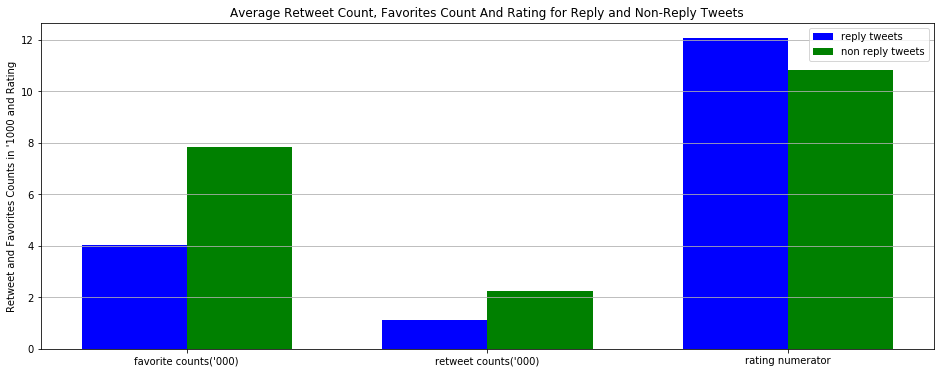

In [61]:
non_reply_tweets = twitter_archive_master[twitter_archive_master.hashtags.isnull()]
reply_tweets = twitter_archive_master[twitter_archive_master.hashtags.notnull()]

non_reply_tweets = twitter_archive_master[twitter_archive_master.in_reply_to_status_id.isnull()]
reply_tweets = twitter_archive_master[twitter_archive_master.in_reply_to_status_id.notnull()]

non_reply_tweets_avg_favorites = non_reply_tweets.favorite_count.mean()/1000
reply_tweets_avg_favorites = reply_tweets.favorite_count.mean()/1000

non_reply_tweets_avg_retweets = non_reply_tweets.retweet_count.mean()/1000
reply_tweets_avg_retweets = reply_tweets.retweet_count.mean()/1000

non_reply_tweets_rating = non_reply_tweets.rating_numerator.mean()
reply_tweets_rating= reply_tweets.rating_numerator.mean()

reply_tweets_heights = [reply_tweets_avg_favorites, reply_tweets_avg_retweets, reply_tweets_rating]
non_reply_tweets_heights = [non_reply_tweets_avg_favorites, non_reply_tweets_avg_retweets, non_reply_tweets_rating]

plt.figure(figsize=(16,6))

plt.bar(x=[1,2,3], height=reply_tweets_heights, width=-0.35, align='edge', color='blue', label='reply tweets', tick_label=["favorite counts('000)", "retweet counts('000)", 'rating numerator']);
plt.bar(x=[1,2,3], height=non_reply_tweets_heights, width=0.35, align='edge', color='green', label='non reply tweets');

plt.ylabel("Retweet and Favorites Counts in '1000 and Rating")

plt.title("Average Retweet Count, Favorites Count And Rating for Reply and Non-Reply Tweets")
plt.grid( axis='y')
plt.legend()
plt.show()


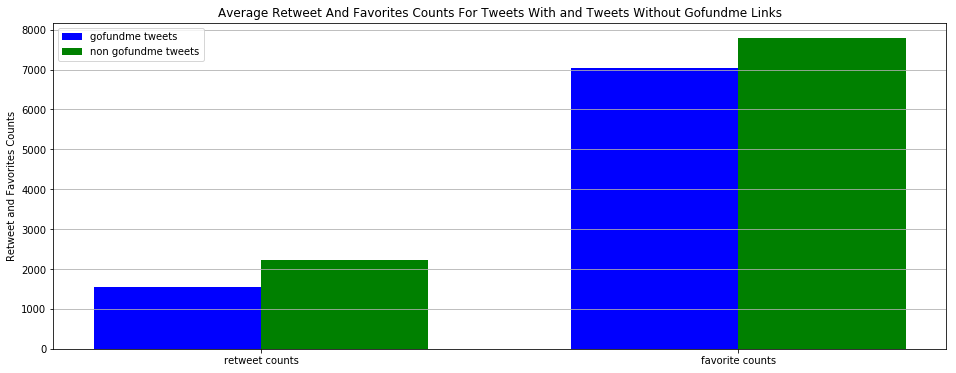

In [62]:
gofundme_tweets = twitter_archive_master[twitter_archive_master['expanded_urls'].apply(lambda x : 'gofundme' in ''.join(x))]
no_gofundme_tweets = twitter_archive_master[twitter_archive_master['expanded_urls'].apply(lambda x : 'gofundme' not in ''.join(x))]
     
gofundme_tweets_avg_retweets = gofundme_tweets.retweet_count.mean()
no_gofundme_tweets_avg_retweets = no_gofundme_tweets.retweet_count.mean()

gofundme_tweets_avg_favorites = gofundme_tweets.favorite_count.mean()
no_gofundme_tweets_avg_favorites = no_gofundme_tweets.favorite_count.mean()
  

gofundme_tweets_avg_retweets_heights = [gofundme_tweets_avg_retweets, gofundme_tweets_avg_favorites]
no_gofundme_tweets_avg_retweets_heights = [no_gofundme_tweets_avg_retweets, no_gofundme_tweets_avg_favorites]

plt.figure(figsize=(16,6))

plt.bar(x=[1,2], height=gofundme_tweets_avg_retweets_heights, width=-0.35, align='edge', color='blue', label='gofundme tweets', tick_label=['retweet counts', 'favorite counts']);
plt.bar(x=[1,2], height=no_gofundme_tweets_avg_retweets_heights, width=0.35, align='edge', color='green', label='non gofundme tweets');

plt.ylabel("Retweet and Favorites Counts")

plt.title("Average Retweet And Favorites Counts For Tweets With and Tweets Without Gofundme Links")
plt.grid(axis='y')
plt.legend()
plt.show()



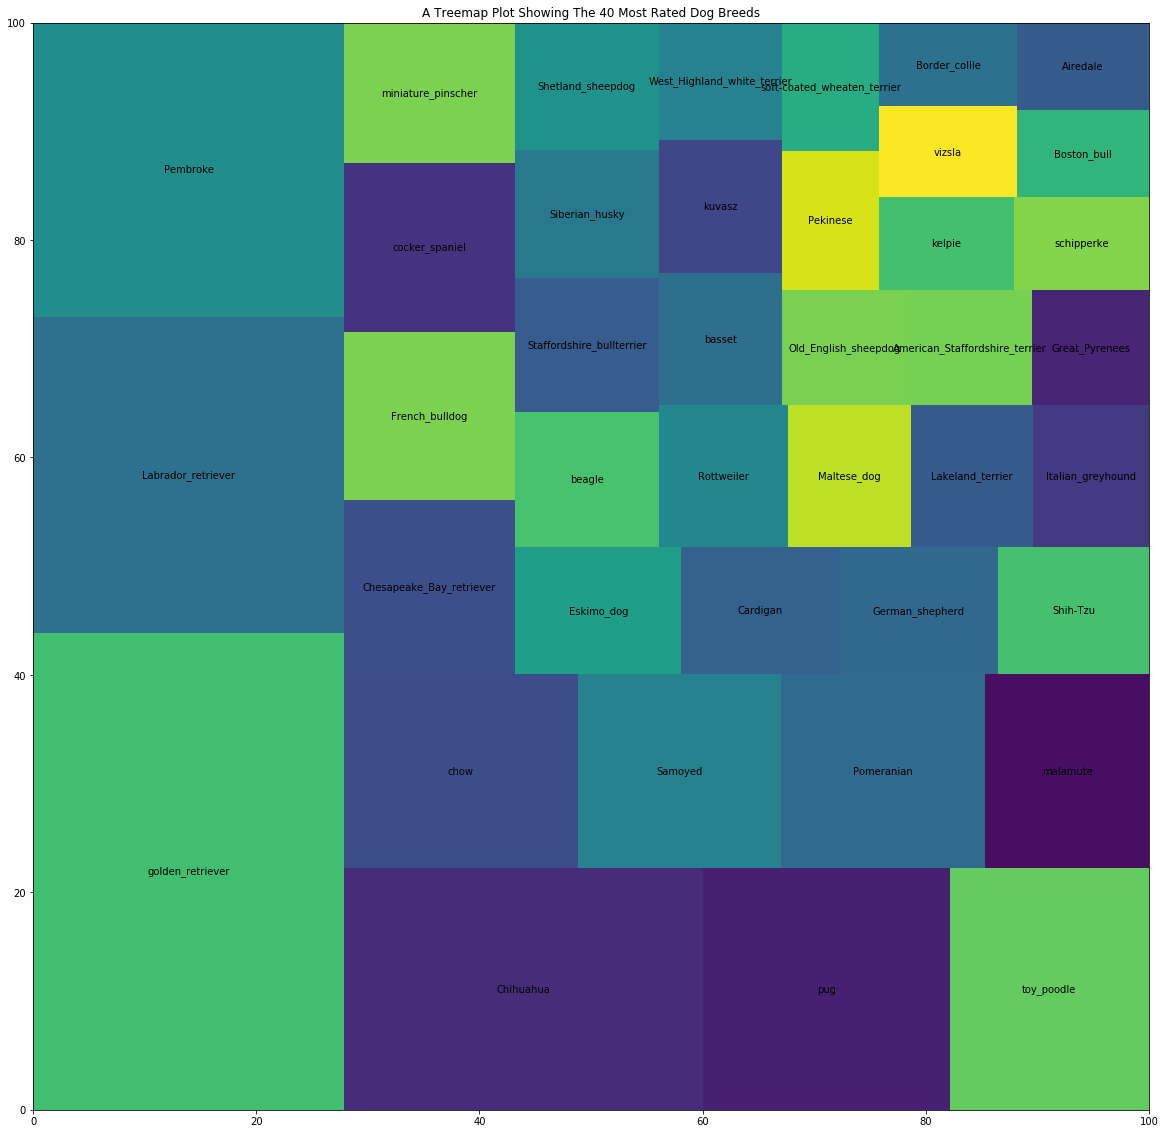

In [63]:
dog_breed_counts = twitter_archive_master.predicted_dog_breed.value_counts()[:40]
plt.figure(figsize=(20,20))
plt.title("A Treemap Plot Showing The 40 Most Rated Dog Breeds")
squarify.plot(sizes=dog_breed_counts, label=dog_breed_counts.index, pad=False);

In [64]:

dog_breed_metrics_df = twitter_archive_master.groupby('predicted_dog_breed')[['rating_numerator', 
                        'prediction_confidence', 'retweet_count', 'favorite_count']].apply(lambda x : x.mean())

dog_breed_metrics_df.rename(columns = lambda x : 'avg_'+x, inplace=True)


dog_breed_metrics_df['num_dogs_rated'] = twitter_archive_master.groupby('predicted_dog_breed')['rating_numerator',
                                                                     ].apply(lambda x : x.count())

dog_breed_metrics_df.sort_values('num_dogs_rated', ascending=False, inplace=True) 

print('\n\n\tVarious Mean Metrics Per Dog Breed, Ranked by The Number of Dogs Rated Per Breed')
dog_breed_metrics_df.head(20)



	Various Mean Metrics Per Dog Breed, Ranked by The Number of Dogs Rated Per Breed


,avg_rating_numerator,avg_prediction_confidence,avg_retweet_count,avg_favorite_count,num_dogs_rated
predicted_dog_breed,,,,,
golden_retriever,11.551948,0.648840,2938.175325,10380.610390,154
Labrador_retriever,11.176471,0.580420,2963.401961,9806.490196,102
Pembroke,11.410526,0.675733,2435.736842,9247.294737,95
Chihuahua,10.555556,0.527118,2126.966667,6855.677778,90
pug,10.241935,0.667843,1488.064516,5098.887097,62
toy_poodle,11.020000,0.471658,1753.180000,5381.560000,50
chow,11.404255,0.547918,2211.255319,7994.000000,47
Samoyed,11.731707,0.710659,3721.682927,11420.365854,41
Pomeranian,10.951220,0.691647,2046.975610,6152.121951,41


In [65]:
distinctive_breeds = dog_breed_metrics_df.sort_values('avg_prediction_confidence', ascending=False).head(5)
print("\n\n\tThe Most Distinctive Looking Breeds")
display(distinctive_breeds)



	The Most Distinctive Looking Breeds


,avg_rating_numerator,avg_prediction_confidence,avg_retweet_count,avg_favorite_count,num_dogs_rated
predicted_dog_breed,,,,,
komondor,11.000000,0.972531,1647.333333,8271.666667,3
keeshond,10.250000,0.844431,1341.500000,4031.250000,4
bull_mastiff,10.400000,0.815618,1166.000000,5032.000000,5
Brittany_spaniel,10.375000,0.775591,1074.625000,4427.625000,8
Bernese_mountain_dog,11.272727,0.766685,1263.181818,6054.636364,11


In [66]:
print(add_color("\tSample Images of The 5 Most Distinctive Looking Dog Breeds :"))
for breed in distinctive_breeds.index:
    sub_df = twitter_archive_master[twitter_archive_master.predicted_dog_breed==breed].sort_values('prediction_confidence').tail(3) #sample(3)
    urls = sub_df['jpg_url'].values
    labels = sub_df['predicted_dog_breed'].values
    conf = ['confidence : ' + str(i) for i in  sub_df['prediction_confidence'].values.astype(list)]
    print(f'\n\n\t{breed.upper()} BREED')
    ipyplot.plot_images(urls, labels, conf, img_width=150, show_url=False)

	Sample Images of The 5 Most Distinctive Looking Dog Breeds :


	KOMONDOR BREED




	KEESHOND BREED




	BULL_MASTIFF BREED




	BRITTANY_SPANIEL BREED




	BERNESE_MOUNTAIN_DOG BREED


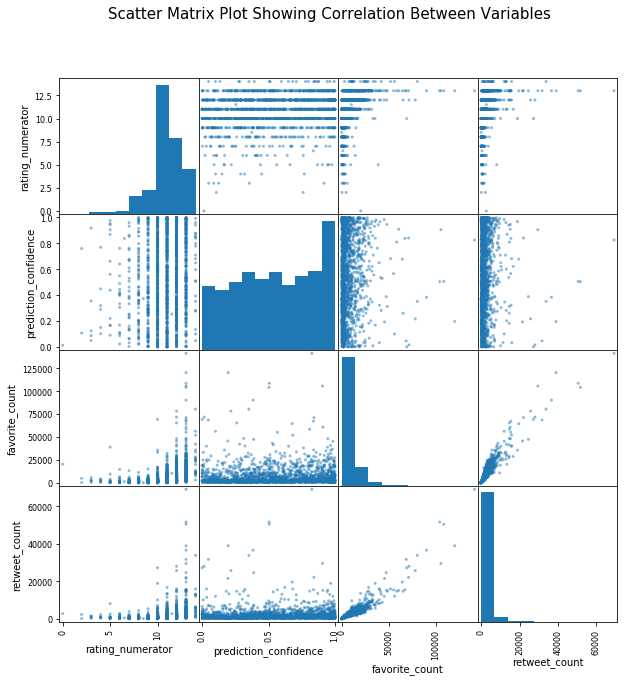

In [67]:
## Plot the scatter plots for some columns of interest to check correlation
scatter_matrix_cols = ['rating_numerator', 'prediction_confidence', 'favorite_count', 'retweet_count', ]
pd.plotting.scatter_matrix(twitter_archive_master[scatter_matrix_cols], figsize=(10,10));
title = "Scatter Matrix Plot Showing Correlation Between Variables"
plt.suptitle(title, fontsize=15);


In [68]:
twitter_archive_master[scatter_matrix_cols].corr()#['rating_numerator']

,rating_numerator,prediction_confidence,favorite_count,retweet_count
rating_numerator,1.000000,0.148068,0.399039,0.304362
prediction_confidence,0.148068,1.000000,0.050471,0.021837
favorite_count,0.399039,0.050471,1.000000,0.930746
retweet_count,0.304362,0.021837,0.930746,1.000000


**The scatter matrix plot shows the strong positive correlation between the favorite count and the retweet count meaning that a tweet with a high number of favorite counts is likely to have a high number of retweets as well.** 

**The plot also shows a positive correlation albeit weak, between the numerical rating and the favorite count. The plot shows a similar correlation between the numerical rating and the retweet count. This shows that the rating given to a dog does not directly predict the number of retweets or likes a tweet is likely to get.**


In [69]:
days_metrics_df = twitter_archive_master.groupby(twitter_archive_master.timestamp.dt.dayofweek)[['favorite_count',
                  'retweet_count']].apply(lambda x : x.mean())

days = ['Sunday', 'Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

days_metrics_df.index = days

days_metrics_df

,favorite_count,retweet_count
Sunday,7577.173285,2173.638989
Monday,8102.319502,2263.012448
Tuesday,8394.940928,2431.185654
Wednesday,7037.219917,1947.763485
Thursday,7639.381356,2177.766949
Friday,8056.368421,2480.028708
Saturday,7691.465438,2165.649770


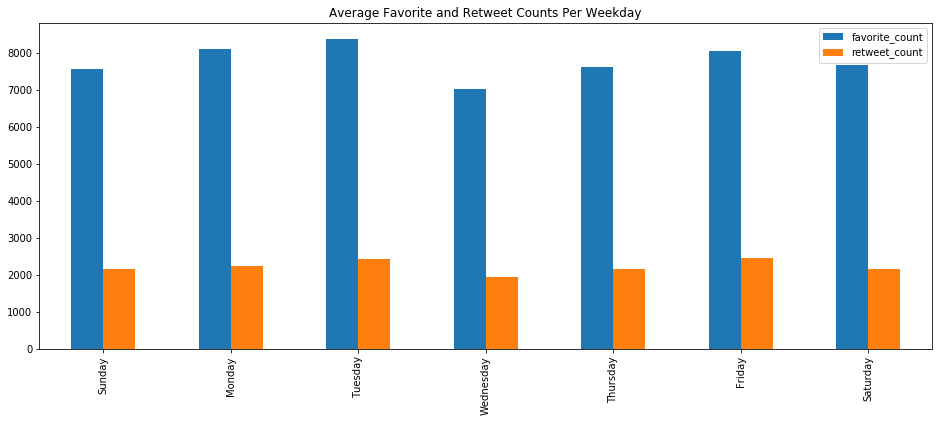

In [70]:
days_metrics_df.plot(kind='bar', figsize=(16,6), title='Average Favorite and Retweet Counts Per Weekday');

**Tweets tweeted on Wednesday recorded the lowest number of average favorite counts with slightly above 7000 favorites. The favorite counts increased from Wednesday through the working days with the average number of favorite counts peaking on Tuesday at about 8400 tweets. There was a slight dip in the upward trend during the weekends with Saturday recording an average of about 7700 favorites and Sunday recording the second lowest number after Wednesday tweets at about 7600 favorites.**

**Wednesday also recorded the lowest number of average retweet counts. However, there was no clear upward trend through the working days from Wednesday. Friday recorded the highest number of average retweet counts, slightly above the number recorded on Tuesdays. The weekend days also recorded among the lowest average retweet counts with  Saturday and Sunday recording the second and third lowest retweets respectively.**

In [71]:
month_metrics_df = twitter_archive_master.groupby(twitter_archive_master.timestamp.dt.month)[['favorite_count',
                    'retweet_count']].apply(lambda x : x.mean())

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

month_metrics_df.index = months

month_metrics_df

,favorite_count,retweet_count
Jan,6943.173469,2192.709184
Feb,8004.954248,2011.228758
Mar,7542.191781,1963.363014
Apr,10240.731707,2605.597561
May,13930.988095,3617.904762
Jun,14902.333333,4254.953704
Jul,13936.393443,3294.729508
Aug,8250.744681,2412.702128
Sep,9126.400000,2774.472727
Oct,10778.644068,3281.186441


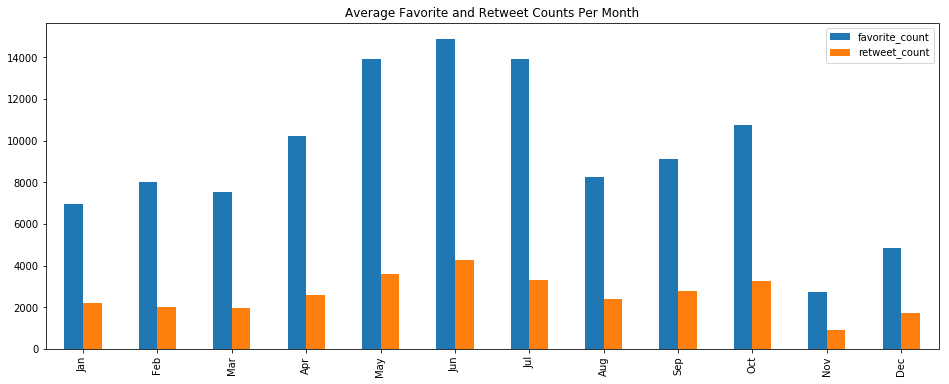

In [72]:
month_metrics_df.plot(kind='bar', figsize=(16,6), title='Average Favorite and Retweet Counts Per Month');

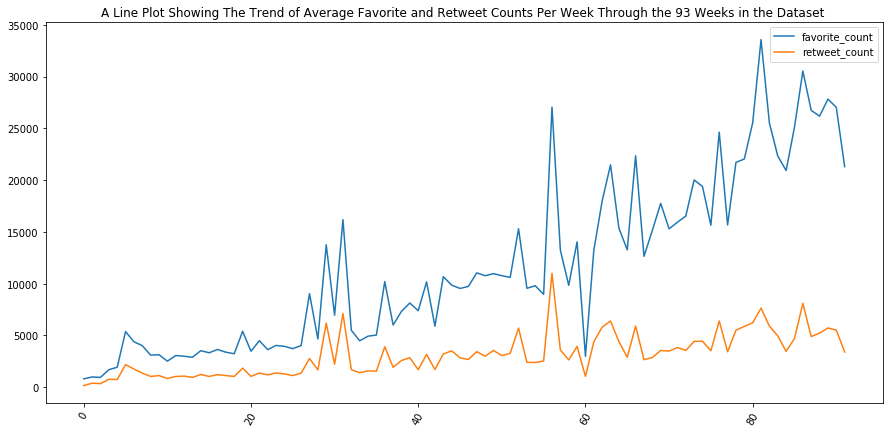

In [73]:
twitter_archive_master['timestamp_year'] = twitter_archive_master.timestamp.dt.year
twitter_archive_master['timestamp_week'] = twitter_archive_master.timestamp.dt.weekofyear

weekly_growth_df = twitter_archive_master[1:].groupby(['timestamp_year', 'timestamp_week'])[['favorite_count','retweet_count']].apply(lambda x : x.mean())
weekly_growth_df['num_of_dogs_rated'] = twitter_archive_master.groupby(['timestamp_year', 'timestamp_week'])['timestamp'].apply(lambda x : x.count())
weekly_growth_df['favorites_retweets_ratio'] = weekly_growth_df['favorite_count']/weekly_growth_df['retweet_count']

title = "A Line Plot Showing The Trend of Average Favorite and Retweet Counts Per Week Through the 93 Weeks in the Dataset "
weekly_growth_df[:-1].plot(y=['favorite_count', 'retweet_count'], use_index=False, figsize=(15,7), title=title, rot=60);

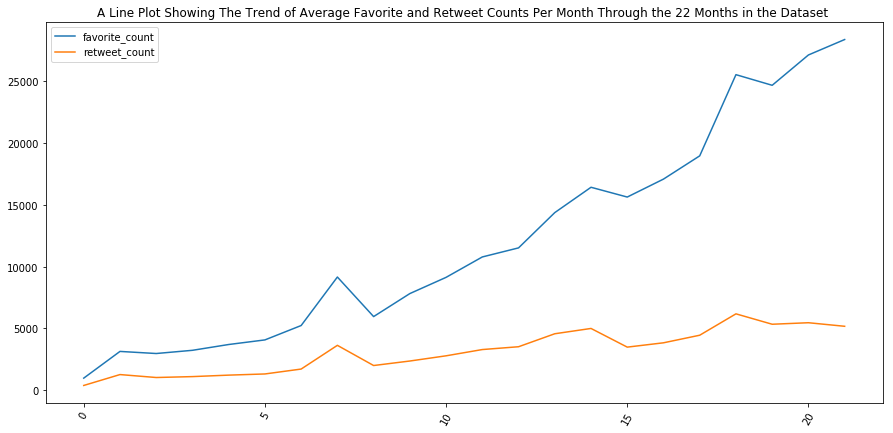

In [74]:
twitter_archive_master['timestamp_year'] = twitter_archive_master.timestamp.dt.year
twitter_archive_master['timestamp_month'] = twitter_archive_master.timestamp.dt.month

monthly_growth_df = twitter_archive_master.groupby(['timestamp_year', 'timestamp_month'])[['favorite_count','retweet_count']].apply(lambda x : x.mean())
monthly_growth_df['num_of_dogs_rated'] = twitter_archive_master.groupby(['timestamp_year', 'timestamp_month'])['timestamp'].apply(lambda x : x.count())
monthly_growth_df['favorites_retweets_ratio'] = monthly_growth_df['favorite_count']/monthly_growth_df['retweet_count']

title = "A Line Plot Showing The Trend of Average Favorite and Retweet Counts Per Month Through the 22 Months in the Dataset "

monthly_growth_df.plot(y=['favorite_count', 'retweet_count'], figsize=(15,7), title=title, use_index=False, rot=60);

In [75]:
def get_slope(df, col):
    return np.polyfit(np.arange(len(df)), df[col].values, 1)[0]

monthly_slope_fav = get_slope(monthly_growth_df, 'favorite_count')
monthly_slope_ret = get_slope(monthly_growth_df, 'retweet_count')
print(f"Monthly Favorites Increase : {monthly_slope_fav}")
print(f"Monthly Retweets Increase  : {monthly_slope_ret}")

Monthly Favorites Increase : 1285.5711044863158
Monthly Retweets Increase  : 249.59691673957352


**Both the weekly and monthly average favorite and retweet count trendlines show an upward trend. The monthly line trend shows a clearer upward trend. There are no signs of a slow down, meaning the Twitter Account @dog_rates is still growing and gaining in the number of retweets and favorites.**

**On average, the favorite and retweet counts per tweet tweeted in a given month increase by around 1287 and 250 respectively per month. For instance, a tweet tweeted in February is likely to get 1287 more favorites than a tweet tweeted in January of the same year.**


### Next we are going to compare the various metrics per dog stage. 
There are four dog stages in the dataset : `puppo`, `floofer`, `pupper` and `doggo`.   
For perspective, here is what each dog stage looks like : 

In [76]:
dog_stages = ['doggo', 'puppo', 'pupper', 'floofer']
for stage in dog_stages :
    sample = twitter_archive_master[twitter_archive_master.dog_stage==stage].sample(5)
    urls = sample.jpg_url.values
    stage_ = sample.dog_stage.values
    print(add_color(f"\n\t\t{stage.upper()}S"))
    ipyplot.plot_images(urls, custom_texts=stage_, show_url=False)


		DOGGOS



		PUPPOS



		PUPPERS



		FLOOFERS


In [77]:
dog_stage_metrics = twitter_archive_master.groupby('dog_stage')[['rating_numerator', 'prediction_confidence', 'favorite_count', 'retweet_count']].apply(lambda x : x.mean())
dog_stage_metrics['num_of_dogs'] = twitter_archive_master.groupby('dog_stage')['rating_numerator'].apply(lambda x : x.count())
dog_stage_metrics

,rating_numerator,prediction_confidence,favorite_count,retweet_count,num_of_dogs
dog_stage,,,,,
doggo,11.905660,0.508401,17324.641509,5825.566038,53
floofer,11.875000,0.577395,11337.125000,3750.250000,8
pupper,10.874286,0.589829,6581.840000,1987.885714,175
puppo,12.000000,0.637540,19891.409091,5609.863636,22


`puppo` dogs recorded the highest average rating of $\frac{12}{10}$. `doggos` then recorded an average rating of $\frac{11.91}{10}$ while `floofer` dogs recorded $\frac{11.88}{10}$, only $\frac{.09}{10}$ and $\frac{.12}{10}$ below the average `puppo` rating. 
`puppers` had by far the lowest average rating at $\frac{10.87}{10}$ which is a distant $\frac{1.13}{10}$ below the average `puppo` rating. 

The average number favorites for each dog stage directly reflected the average rating of each dog stage with `puppos` having the highest average number of favorites at about $19,915$ and `puppers` having the lowest average favorite counts at $6,590$. Surprisingly, `doggos` had slightly higher average retweets than `puppos` at $5,844$ and $5,629$ respectively. 

### Dogs with Highest Number of Retweets And  Favorites

> We will now look at the Individual Dogs with the highest number of favorites and retweets to hopefully identify a common characteristic between them

In [78]:
highest_counts_df = twitter_archive_master.sort_values('retweet_count', ascending=False).head(10)
print(add_color("\n\tTop 10 Dogs With The Highest Number of Favorites And Retweets"))
display(highest_counts_df)

urls =  highest_counts_df['jpg_url'].values
custom_texts = 'favorites : ' + highest_counts_df['favorite_count'].astype(str) + ' \nretweets : ' + highest_counts_df['retweet_count'].astype(str)
ipyplot.plot_images(urls, custom_texts=custom_texts, show_url=False)    


	Top 10 Dogs With The Highest Number of Favorites And Retweets


,in_reply_to_status_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage,jpg_url,predicted_dog_breed,prediction_confidence,favorite_count,hashtags,retweet_count,user_mentions,timestamp_year,timestamp_week,timestamp_month
tweet_id,,,,,,,,,,,,,,,,,,
744234799360020481,NaN,2016-06-18 18:26:18,Twitter for iPhone,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,[https://twitter.com/dog_rates/status/744234799360020481/video/1],13.0,NaN,doggo,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,Labrador_retriever,0.825333,141313,NaN,69161,NaN,2016,24,6
739238157791694849,NaN,2016-06-04 23:31:25,Twitter for iPhone,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,[https://twitter.com/dog_rates/status/739238157791694849/video/1],13.0,NaN,doggo,https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg,Eskimo_dog,0.503372,104257,NaN,51659,NaN,2016,22,6
807106840509214720,NaN,2016-12-09 06:17:20,Twitter for iPhone,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,[https://twitter.com/dog_rates/status/807106840509214720/video/1],13.0,Stephan,NaN,https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg,Chihuahua,0.505370,108628,NaN,50491,NaN,2016,49,12
822872901745569793,NaN,2017-01-21 18:26:02,Twitter for iPhone,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,[https://twitter.com/dog_rates/status/822872901745569793/photo/1],13.0,NaN,puppo,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,Lakeland_terrier,0.196015,120326,WomensMarch,38974,NaN,2017,3,1
879415818425184262,NaN,2017-06-26 19:07:24,Twitter for iPhone,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY,[https://twitter.com/dog_rates/status/879415818425184262/video/1],13.0,Duddles,NaN,https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg,English_springer,0.383404,90230,NaN,36599,NaN,2017,26,6
819004803107983360,NaN,2017-01-11 02:15:36,Twitter for iPhone,This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1,[https://twitter.com/dog_rates/status/819004803107983360/photo/1],14.0,Bo,doggo,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,standard_poodle,0.351308,80437,NaN,33790,NaN,2017,2,1
806629075125202948,NaN,2016-12-07 22:38:52,Twitter for iPhone,"""Good afternoon class today we're going to learn what makes a good boy so good"" 13/10 https://t.co/f1h2Fsalv9",[https://twitter.com/dog_rates/status/806629075125202948/photo/1],13.0,NaN,NaN,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,cocker_spaniel,0.046403,68645,NaN,31693,NaN,2016,49,12
866450705531457537,NaN,2017-05-22 00:28:40,Twitter for iPhone,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr",[https://twitter.com/dog_rates/status/866450705531457537/photo/1],13.0,Jamesy,pupper,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,French_bulldog,0.905334,105583,NaN,29501,NaN,2017,21,5
678399652199309312,NaN,2015-12-20 02:20:55,Twitter for iPhone,This made my day. 12/10 please enjoy https://t.co/VRTbo3aAcm,[https://twitter.com/dog_rates/status/678399652199309312/video/1],12.0,NaN,NaN,https://pbs.twimg.com/ext_tw_video_thumb/678399528077250560/pu/img/BOjUNHRsYLeSo0hl.jpg,Bedlington_terrier,0.015047,71685,NaN,27988,NaN,2015,51,12


**It so happens that of the first 5 tweets with the highest retweet counts, 3 of them are tweets with video postings as can be seen in the tweet text column. These tweets include "(vid by@user_name)" in the text column.**

**We will look at the entire dataset for other tweets with videos and compare the average retweets and favorites with the averages of the entire dataset**

In [79]:
vid_tweets = twitter_archive_master[twitter_archive_master.text.str.extract(r'(vid by)').notnull()[0]]
vid_tweets[['text', 'favorite_count', 'retweet_count']].sort_values('favorite_count', ascending=False)

,text,favorite_count,retweet_count
tweet_id,,,
744234799360020481,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,141313,69161
739238157791694849,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,104257,51659
879415818425184262,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY,90230,36599
817827839487737858,This is Buddy. He ran into a glass door once. Now he's h*ckin skeptical. 13/10 empowering af (vid by Brittany Gaunt) https://t.co/q2BgNIi3OA,47408,24580
863553081350529029,This is Neptune. He's a backpup vocalist for the Dixie Chicks. 13/10 (vid by @AmiWinehouse) https://t.co/tordvmaaop,13254,3565
821407182352777218,This is Sundance. He's a doggo drummer. Even sings a bit on the side. 14/10 entertained af (vid by @sweetsundance) https://t.co/Xn5AQtiqzG,10816,3922
752334515931054080,Here's a doggo trying to catch some fish. 8/10 futile af (vid by @KellyBauerx) https://t.co/jwd0j6oWLE,3501,989
751456908746354688,Here's a pupper that's very hungry but too lazy to get up and eat. 12/10 (vid by @RealDavidCortes) https://t.co/lsVAMBq6ex,2930,910
685663452032069632,Meet Brooks. He's confused by the almighty ball of tennis. 12/10 \n\n(vid by @PDolan37) https://t.co/AcVWe39nmM,2911,1308


In [80]:
avg_vid_tweets_likes = vid_tweets.favorite_count.mean()
avg_overall_likes = twitter_archive_master.favorite_count.mean()
avg_vid_tweets_retweets = vid_tweets.retweet_count.mean()
avg_overall_retweets = twitter_archive_master.retweet_count.mean()
print(f"Average Favorites For Tweets with Videos : {avg_vid_tweets_likes}")
print(f"Overall Average Favorites                : {avg_overall_likes}\n")
print(f"Average Retweets For Tweets with Videos : {avg_vid_tweets_retweets}")
print(f"Overall Average Retweets                : {avg_overall_retweets}")


Average Favorites For Tweets with Videos : 35180.083333333336
Overall Average Favorites                : 7776.133896260555

Average Retweets For Tweets with Videos : 16223.333333333334
Overall Average Retweets                : 2228.776236429433


<a name="insight1"></a>

As can be seen above, not all tweets with videos get the highest number of likes. Tweets with videos got likes ranging from 1526 to the highest of 141,531. However, the tweets with videos averaged at about $35,235$ favorites and $16,276$ retweets, each way above the overall average favorite and retweet counts throughout the dataset which were $7,786$ and $2,235$ respectively. 

This means that **tweets with videos are likely to get 5 times as many likes and 7 times as many retweets as tweets with only pictures**

<a name="insights"></a>

### Insights
The following insights were gathered from analysis of the cleaned master dataset:

1. Tweets tweeted on Wednesday are likely to get the least number of favorites and retweets while tweets tweeted on Tuesday are likely to get the highest number of favorites

2. Tweets with [`Gofundme`](https://www.gofundme.com/)`(a crowdfunding platform)` links do not get more retweets or favorites for exposure as would be expected since WeRateDogs® is also a non-profit organization concerned with rescuing dogs and seeking treatment for sick dogs. Instead, they actually get less retweets and favorites. 

3. As seen [here](#insight1), Tweets with videos are likely to get 5 times as many likes and 7 times as many retweets as tweets with only pictures

4. Reply tweets are likely to get half as many retweets and favorites as compared to original tweets directly tweeted by @dog_rates. However, the dogs on reply tweets on average get higher ratings at slightly above $\frac{12}{10}$ while the dogs on tweets directly tweeted by @dog_rates on average get a rating slightly below $\frac{11}{10}$

5.  A tweet with a high number of favorite counts is likely to have a high number of retweets as well. On the other hand, the rating given to a dog does not directly predict the number of retweets or likes a tweet is likely to get.